# Fallback Table Metalearning Scripting
- Takes as input preds_df output from predictions_metalearning
- Supplements with fallback
- Computes overall model performance
- Engineers features at tld-reseller level
- Trains metalearning model(s) to assign model based on features
- Assigns model based on previous

In [15]:
options(repr.matrix.max.cols=50, repr.matrix.max.rows=100)

In [16]:
# install.packages("pkgcond")

In [17]:
library(dplyr)
library(data.table)
library(partykit)
library(tictoc)
library(caret)
library(e1071)
library(randomForest)
library(ranger)

#for 3d plotting
library(akima)
library(plotly)

# for prep data
library(stringr)
library(pbapply)
library(stringdist)
library(data.table)
library(dominanceanalysis)


getwd()

[1] "/home/jupyter/Domains_202003/scripts/phaseII_06_fallbacksupp"

In [23]:

source('../orig/functions.R')

source('../orig/functions_models.R')

source('../phaseII_03_forest/functions_eval.R')


In [24]:
source('functions_metalearning.R')

In [25]:
source('functions_fallback.R')

In [26]:
dataDir='/home/jupyter/Domains_202003/data/output/datapull_20201116'

modelDir='/home/jupyter/Domains_202003/data/output/models_20201104'

outputDir='/home/jupyter/Domains_202003/data/output/datapull_20201127'

In [27]:
# data defined in this notebook
metametrics_df <- read.csv("../../data/output/metametrics_df.csv")
new_metametrics_imp_pred_df <- read.csv( "../../data/output/new_metametrics_imp_pred_df.csv")
geoLookupDF <- read.csv("/home/jupyter/Domains_202003/data/input/PredictiveModelAnalysis_ResellerGeoMap.csv")

In [28]:
# new data pull
expiry_new_df <- readRDS(file.path(outputDir,"expiry_20200902_20201102_20201127"))
expiry_new_df <- expiry_new_df %>% filter(expiry_date < "2020-10-08")
expiry_new_df <- expiry_new_df %>% filter(!is.na(gibb_score))
expiry_new_df <- expiry_new_df %>% mutate (reg_arpt = ifelse(reg_arpt <= 0, 0.0001,reg_arpt),
                                   log_reg_arpt = log(reg_arpt),
                                   tld_registrar_index = tolower(paste(tld, reseller,sep="")))
expiry_new_df <- geo_suppl(expiry_new_df, geoLookupDF = geoLookupDF)

Expiry data originally has 476586 rows and 476586 missing geo's.
... after intial merge on reseller & _country, expiry has 476586 rows and 476408 missing geo's.
... after secondary fill with _country, expiry has 476586 rows and 496 missing geo's.
... after manual tweaks with _country, expiry has 476586 rows and 71 missing geo's.


# LOAD DATA

In [29]:

# Load preds output from predictions_metalearning.R
expiry_df_test_preds <- read.csv("../../data/output/datapull_20201116/expiry_df_test_preds.csv")

# Load training data used for predictions_metalearning.R to assign fallback values
expiry_df_train <- read.csv("../../data/output/datapull_20201116/expiry_df_train.csv")

# Load geo_suppl for train and test-pred data
geoLookupDF <- read.csv("/home/jupyter/Domains_202003/data/input/PredictiveModelAnalysis_ResellerGeoMap.csv")


In [30]:
# Supplement both train and test_preds with geo information
expiry_df_train_g <- geo_suppl(expiry_df_train, geoLookupDF = geoLookupDF)
expiry_df_test_preds_g <- geo_suppl(expiry_df_test_preds, geoLookupDF = geoLookupDF)

Expiry data originally has 3729384 rows and 3729384 missing geo's.
... after intial merge on reseller & _country, expiry has 3729384 rows and 3726455 missing geo's.
... after secondary fill with _country, expiry has 3729384 rows and 6983 missing geo's.
... after manual tweaks with _country, expiry has 3729384 rows and 29 missing geo's.
Expiry data originally has 932347 rows and 932347 missing geo's.
... after intial merge on reseller & _country, expiry has 932347 rows and 931606 missing geo's.
... after secondary fill with _country, expiry has 932347 rows and 1741 missing geo's.
... after manual tweaks with _country, expiry has 932347 rows and 8 missing geo's.


# SUPPL FALLBACK

In [72]:
# generate list of fallback tables
npv_fallback_list = fallback_gen( npv_historic_renewal_data = expiry_df_train_g, 
                                 reseller_am_geo_map = geoLookupDF)

# return list members to in-memory objects of the same name
names(npv_fallback_list)
for(i in 1:length(npv_fallback_list)) assign(names(npv_fallback_list)[i], npv_fallback_list[[i]])

`summarise()` regrouping output by 'tld', 'reseller_geo' (override with `.groups` argument)

`summarise()` regrouping output by 'reseller_geo' (override with `.groups` argument)

`summarise()` regrouping output by 'tld' (override with `.groups` argument)

`summarise()` regrouping output by 'tld' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` regrouping output by 'tld' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` regrouping output by 'region' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



[1] "npv_fallback_first_geo_arpt_tld" "npv_fallback_first_geo_arpt"    
 [3] "npv_fallback_first_tld_arpt"     "npv_fallback_second_tld_geo"    
 [5] "npv_fallback_second_geo"         "npv_fallback_third_tld_geo"     
 [7] "npv_fallback_third_geo"          "npv_fallback_first_final"       
 [9] "npv_fallback_second_final"       "npv_fallback_third_final"

In [73]:
# generate list of low-volume tld-re's from training data
tld_registrar_excl_list = tld_registrar_excl_df(expiry_df_train_g)

# generate placeholder (*_fb) columns in preds df where predictions for low-volume tld-registrars get set to NA
expiry_df_test_preds_g <- expiry_df_test_preds_g %>%
     mutate( across(contains('pred_'), 
                    .fns = list(fb = ~ifelse(tld_registrar_index %in% tld_registrar_excl_list, NA, . )) ))

Excluding 1706 tld-re's (80.89%), due to volume < 500 
Excluding 157 tld-re's (7.44%) associated with tld's 'pw' and 'in.net' 


In [74]:
# apply fallback tables TST
expiry_df_test_preds_g <- fallback_app_1(test_data_op=expiry_df_test_preds_g,
               in_col='pred_seg2_rf_ALL_fb',
               out_col='pred_seg2_rf_ALL_fb2')
expiry_df_test_preds_g <- fallback_app_1(test_data_op=expiry_df_test_preds_g,
               in_col='pred_seg2_glm_ALL_fb',
               out_col='pred_seg2_glm_ALL_fb2')
expiry_df_test_preds_g <- fallback_app_1(test_data_op=expiry_df_test_preds_g,
               in_col='pred_seg_rf_ALL_fb',
               out_col='pred_seg_rf_ALL_fb2')
expiry_df_test_preds_g <- fallback_app_1(test_data_op=expiry_df_test_preds_g,
               in_col='pred_seg_glm_ALL_fb',
               out_col='pred_seg_glm_ALL_fb2')
expiry_df_test_preds_g <- fallback_app_1(test_data_op=expiry_df_test_preds_g,
               in_col='pred_agg_rf_fb',
               out_col='pred_agg_rf_fb2')
expiry_df_test_preds_g <- fallback_app_1(test_data_op=expiry_df_test_preds_g,
               in_col='pred_agg_glm_fb',
               out_col='pred_agg_glm_fb2')
expiry_df_test_preds_g <- fallback_app_1(test_data_op=expiry_df_test_preds_g,
               in_col='pred_agg_rf_ALL_fb',
               out_col='pred_agg_rf_ALL_fb2')
expiry_df_test_preds_g <- fallback_app_1(test_data_op=expiry_df_test_preds_g,
               in_col='pred_agg_glm_ALL_fb',
               out_col='pred_agg_glm_ALL_fb2')

# GENERATE Tld-reseller level Performance Metrics from preds DF

In [75]:
metrics_df <- expiry_df_test_preds_g %>%
  group_by(tld_registrar_index) %>%
  do( l10_seg2_glm = l10_dplyr(., pred_var = "pred_seg2_glm_ALL"),
      l10_seg_glm = l10_dplyr(., pred_var = "pred_seg_glm_ALL"),
       l10_agg_glm_ALL = l10_dplyr(., pred_var = "pred_agg_glm_ALL"),
       l10_agg_glm = l10_dplyr(., pred_var = "pred_agg_glm"),
       l10_seg2_rf = l10_dplyr(., pred_var = "pred_seg2_rf_ALL"),
       l10_seg_rf = l10_dplyr(., pred_var = "pred_seg_rf_ALL"),
       l10_agg_rf = l10_dplyr(., pred_var = "pred_agg_rf"),
       l10_agg_rf_ALL = l10_dplyr(., pred_var = "pred_agg_rf_ALL"),
     
      auc_seg2_glm = auc_dplyr(., pred_var = "pred_seg2_glm_ALL"),
      auc_seg_glm = auc_dplyr(., pred_var = "pred_seg_glm_ALL"),
       auc_agg_glm_ALL = auc_dplyr(., pred_var = "pred_agg_glm_ALL"),
       auc_agg_glm = auc_dplyr(., pred_var = "pred_agg_glm"),
       auc_seg2_rf = auc_dplyr(., pred_var = "pred_seg2_rf_ALL"),
       auc_seg_rf = auc_dplyr(., pred_var = "pred_seg_rf_ALL"),
       auc_agg_rf_ALL = auc_dplyr(., pred_var = "pred_agg_rf_ALL"),
       auc_agg_rf = auc_dplyr(., pred_var = "pred_agg_rf"),
      
     l10_seg2_glm_fb = l10_dplyr(., pred_var = "pred_seg2_glm_ALL_fb2"),
      l10_seg_glm_fb = l10_dplyr(., pred_var = "pred_seg_glm_ALL_fb2"),
       l10_agg_glm_fb = l10_dplyr(., pred_var = "pred_agg_glm_fb2"),
       l10_agg_glm_ALL_fb = l10_dplyr(., pred_var = "pred_agg_glm_ALL_fb2"),
       l10_seg2_rf_fb = l10_dplyr(., pred_var = "pred_seg2_rf_ALL_fb2"),
       l10_seg_rf_fb = l10_dplyr(., pred_var = "pred_seg_rf_ALL_fb2"),
       l10_agg_rf_fb = l10_dplyr(., pred_var = "pred_agg_rf_fb2"),
       l10_agg_rf_ALL_fb = l10_dplyr(., pred_var = "pred_agg_rf_ALL_fb2"),
     
      auc_seg2_glm_fb = auc_dplyr(., pred_var = "pred_seg2_glm_ALL_fb2"),
      auc_seg_glm_fb = auc_dplyr(., pred_var = "pred_seg_glm_ALL_fb2"),
       auc_agg_glm_fb = auc_dplyr(., pred_var = "pred_agg_glm_fb2"),
       auc_agg_glm_ALL_fb = auc_dplyr(., pred_var = "pred_agg_glm_ALL_fb2"),
       auc_seg2_rf_fb = auc_dplyr(., pred_var = "pred_seg2_rf_ALL_fb2"),
       auc_seg_rf_fb = auc_dplyr(., pred_var = "pred_seg_rf_ALL_fb2"),
       auc_agg_rf_fb = auc_dplyr(., pred_var = "pred_agg_rf_fb2"),
       auc_agg_rf_ALL_fb = auc_dplyr(., pred_var = "pred_agg_rf_ALL_fb2"),
      )


In [76]:
head(metrics_df)

tld_registrar_index,l10_seg2_glm,l10_seg_glm,l10_agg_glm_ALL,l10_agg_glm,l10_seg2_rf,l10_seg_rf,l10_agg_rf,l10_agg_rf_ALL,auc_seg2_glm,auc_seg_glm,auc_agg_glm_ALL,auc_agg_glm,auc_seg2_rf,auc_seg_rf,auc_agg_rf_ALL,auc_agg_rf,l10_seg2_glm_fb,l10_seg_glm_fb,l10_agg_glm_fb,l10_agg_glm_ALL_fb,l10_seg2_rf_fb,l10_seg_rf_fb,l10_agg_rf_fb,l10_agg_rf_ALL_fb,auc_seg2_glm_fb,auc_seg_glm_fb,auc_agg_glm_fb,auc_agg_glm_ALL_fb,auc_seg2_rf_fb,auc_seg_rf_fb,auc_agg_rf_fb,auc_agg_rf_ALL_fb
<fct>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>
fun1&1 internet,0,0,0,0,0,1.666667,1.666667,1.666667,0.4666667,0.45,0.45,0.45,0.5333333,0.5333333,0.55,0.6166667,1.666667,1.666667,1.666667,1.666667,1.666667,1.666667,1.666667,1.666667,0.65,0.65,0.65,0.65,0.65,0.65,0.65,0.65
fun10dencehispahard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fun1api,0,0,2.5,0,0,2.5,0,0,0.4,0.45,0.55,0.425,0.35,0.475,0.35,0.55,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,0.425,0.425,0.425,0.425,0.425,0.425,0.425,0.425
funab name isp,3.333333,3.333333,3.333333,3.333333,3.333333,6.666667,6.666667,3.333333,0.5166667,0.7166667,0.5166667,0.4833333,0.65,0.65,0.6833333,0.7833333,6.666667,6.666667,6.666667,6.666667,6.666667,6.666667,6.666667,6.666667,0.8833333,0.8833333,0.8833333,0.8833333,0.8833333,0.8833333,0.8833333,0.8833333
funactive 24,2,0,2,2,4,2,0,2,0.63,0.37,0.49,0.47,0.67,0.65,0.65,0.63,0,0,0,0,0,0,0,0,0.53,0.53,0.53,0.53,0.53,0.53,0.53,0.53
funalibaba,5,5.028329,4.773371,4.730878,7.76204,7.691218,7.790368,7.832861,0.8390935,0.8284703,0.8087819,0.8077904,0.9164306,0.9165722,0.91983,0.9189802,5,5.028329,4.730878,4.773371,7.76204,7.691218,7.790368,7.832861,0.8390935,0.8284703,0.8077904,0.8087819,0.9164306,0.9165722,0.9189802,0.91983


# FEATURE ENGINEERING at tld-reseller level 

In [149]:
meta_df = expiry_df_test_preds_g %>%
  add_count(tld_registrar_index, reseller_geo) %>%
  group_by(tld_registrar_index) %>%
  summarise(
            geo_maj = reseller_geo[n == max(n)][1],
            geo_cnt = n_distinct(reseller_geo),
            n = n(),
            ren_prp = sum(renewal_status=='Renewed')/sum(n),
            tld_cnt = n_distinct(tld), tld_rat = tld_cnt/n,
              
            daydom_min = min(day_domains), 
            daydom_max = max(day_domains), 
            daydom_mean = mean(day_domains, na.rm = TRUE), 
            daydom_rng = daydom_max - daydom_min, 
            daydom_std = sd(day_domains, na.rm = TRUE), 
            daydom_skew = skewness(day_domains, na.rm = TRUE), 
            daydom_kurt = kurtosis(day_domains, na.rm = TRUE),

            sldlen_min = min(sld_length), 
            sldlen_max = max(sld_length), 
            sldlen_mean = mean(sld_length, na.rm = TRUE), 
            sldlen_rng = sldlen_max - sldlen_min, 
            sldlen_std = sd(sld_length, na.rm = TRUE), 
            sldlen_skew = skewness(sld_length, na.rm = TRUE), 
            sldlen_kurt = kurtosis(sld_length, na.rm = TRUE),
  
            gibbs_min = min(gibb_score), 
            gibbs_max = max(gibb_score), 
            gibbs_mean = mean(gibb_score, na.rm = TRUE), 
            gibbs_rng = gibbs_max - gibbs_min, 
            gibbs_std = sd(gibb_score, na.rm = TRUE), 
            gibbs_skew = skewness(gibb_score, na.rm = TRUE), 
            gibbs_kurt = kurtosis(gibb_score, na.rm = TRUE),
  
            pdcnt_min = min(pattern_domain_count), 
            pdcnt_max = max(pattern_domain_count), 
            pdcnt_mean = mean(pattern_domain_count, na.rm = TRUE), 
            pdcnt_rng = pdcnt_max - pdcnt_min, 
            pdcnt_std = sd(pattern_domain_count, na.rm = TRUE), 
            pdcnt_skew = skewness(pattern_domain_count, na.rm = TRUE), 
            pdcnt_kurt = kurtosis(pattern_domain_count, na.rm = TRUE),
  
            regarpt_min = min(reg_arpt), 
            regarpt_max = max(reg_arpt), 
            regarpt_mean = mean(reg_arpt, na.rm = TRUE), 
            regarpt_rng = regarpt_max - regarpt_min, 
            regarpt_std = sd(reg_arpt, na.rm = TRUE), 
            regarpt_skew = skewness(reg_arpt, na.rm = TRUE), 
            regarpt_kurt = kurtosis(reg_arpt, na.rm = TRUE))

# add a handful more vars 
country_maj = expiry_df_test_preds_g %>%
  add_count(tld_registrar_index, reseller_country) %>%
  group_by(tld_registrar_index) %>%
  mutate(reseller_country_maj = reseller_country[n == max(n)][1]) %>%
  select(-n) %>% 
  group_by(tld_registrar_index,reseller_country_maj) %>%
    summarise(n = n()) %>% 
    arrange(desc(n)) %>%
    pull(reseller_country_maj)

country_cnt = expiry_df_test_preds_g %>%
  add_count(tld_registrar_index, reseller_country) %>%
  group_by(tld_registrar_index) %>%
  summarise(reseller_country_cnt = n_distinct(reseller_country)) %>%
  pull(reseller_country_cnt)  

region_maj = expiry_df_test_preds_g %>%
  add_count(tld_registrar_index, region) %>%
  group_by(tld_registrar_index) %>%
  mutate(region_maj = region[n == max(n)][1]) %>%
  select(-n) %>% 
  group_by(tld_registrar_index,region_maj) %>%
    summarise(n = n()) %>% 
    arrange(desc(n)) %>%
    pull(region_maj)

region_cnt = expiry_df_test_preds_g %>%
  add_count(tld_registrar_index, region) %>%
  group_by(tld_registrar_index) %>%
  summarise(reseller_region_cnt = n_distinct(reseller_country)) %>%
  pull(reseller_region_cnt)  

meta_df = meta_df %>% 
    mutate(country_maj = country_maj,
            region_maj = region_maj,
            country_cnt = country_cnt,
            region_cnt = region_cnt,
            )

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` regrouping output by 'tld_registrar_index' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` regrouping output by 'tld_registrar_index' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



# JOIN preds metrics with pred meta

In [150]:
metametrics_df <- merge(meta_df, metrics_df, on = 'tld_registrar_index', all = TRUE)

In [151]:
dim(metametrics_df)

[1] 1758   78


# ADD win flags for seg2_glm vs. seg2_gm_fb vs. agg_rf_ALL


In [152]:
(auc_vars = c('auc_seg2_glm','auc_agg_rf_ALL','auc_seg2_glm_fb'))
(l10_vars = c('l10_seg2_glm','l10_agg_rf_ALL','l10_seg2_glm_fb'))

metametrics_df <- metametrics_df %>%
    mutate (auc_win_04=sapply(apply(.[,c(auc_vars)], 
                          1, function(x) names(x)[which.max(x)]) , function(s) if (length(s) == 0) NA else paste(s, collapse = " ")) ,
            l10_win_04=sapply(apply(.[,c(l10_vars)], 
                          1, function(x) names(x)[which.max(x)]), function(s) if (length(s) == 0) NA else paste(s, collapse = " ")) 
            ) 

[1] "auc_seg2_glm"    "auc_agg_rf_ALL"  "auc_seg2_glm_fb"

[1] "l10_seg2_glm"    "l10_agg_rf_ALL"  "l10_seg2_glm_fb"

In [154]:
metametrics_df <- metametrics_df %>% mutate_if(is.list,as.numeric) 
dim(metametrics_df)

[1] 1758   80

In [155]:
write.csv(metametrics_df, "../../data/output/metametrics_df.csv", row.names=FALSE)

In [138]:
metametrics_df <- read.csv("../../data/output/metametrics_df.csv")

# IMPUTE missing values

In [156]:
# remove observations with missing wins -- we don't want to impute these dependent variables 
metametrics_df <- metametrics_df %>% filter(!is.na(auc_win_04))

In [157]:
# install.packages("missRanger")
library(missRanger)

In [158]:
metametrics_imp_df <- missRanger(metametrics_df, num.trees = 100)


Missing value imputation by random forests

  Variables to impute:		geo_maj, daydom_std, daydom_skew, daydom_kurt, sldlen_std, sldlen_skew, sldlen_kurt, gibbs_std, gibbs_skew, gibbs_kurt, pdcnt_std, pdcnt_skew, pdcnt_kurt, regarpt_std, regarpt_skew, regarpt_kurt
  Variables used to impute:	tld_registrar_index, geo_maj, geo_cnt, n, ren_prp, tld_cnt, tld_rat, daydom_min, daydom_max, daydom_mean, daydom_rng, daydom_std, daydom_skew, daydom_kurt, sldlen_min, sldlen_max, sldlen_mean, sldlen_rng, sldlen_std, sldlen_skew, sldlen_kurt, gibbs_min, gibbs_max, gibbs_mean, gibbs_rng, gibbs_std, gibbs_skew, gibbs_kurt, pdcnt_min, pdcnt_max, pdcnt_mean, pdcnt_rng, pdcnt_std, pdcnt_skew, pdcnt_kurt, regarpt_min, regarpt_max, regarpt_mean, regarpt_rng, regarpt_std, regarpt_skew, regarpt_kurt, country_maj, region_maj, country_cnt, region_cnt, l10_seg2_glm, l10_seg_glm, l10_agg_glm_ALL, l10_agg_glm, l10_seg2_rf, l10_seg_rf, l10_agg_rf, l10_agg_rf_ALL, auc_seg2_glm, auc_seg_glm, auc_agg_glm_ALL, auc_agg

Warning message:
“Dropped unused factor level(s) in dependent variable: Middle East.”


................
iter 2:	

Warning message:
“Dropped unused factor level(s) in dependent variable: Middle East.”


................
iter 3:	

Warning message:
“Dropped unused factor level(s) in dependent variable: Middle East.”


................
iter 4:	

Warning message:
“Dropped unused factor level(s) in dependent variable: Middle East.”


................


# Train Models 

In [159]:
# l10

#Compute weights to balance the RF
Y = metametrics_imp_df$l10_win_04
w <- 1/table(Y)
w <- w/sum(w)

weights <- rep(0, length(Y))

for (model in unique(Y)){
    weights[Y==model] <- w[model]
}


model_l10 <- ranger(formula         = l10_win_04 ~ ., 
                data            = metametrics_imp_df %>% 
                                    select('l10_win_04') %>% 
                                    bind_cols(
                                        metametrics_imp_df %>% 
                                        select(-contains('auc'),-contains('l10'),-'tld_registrar_index', -'tld_rat')), 
                importance = 'impurity', 
                num.trees       = 500,
                probability = TRUE,
                replace = FALSE,
                sample.fraction = .8,
                seed            = 123,
                respect.unordered.factors=TRUE,
               case.weights=weights)
                           
# auc
                                        
#Compute weights to balance the RF
Y = metametrics_imp_df$auc_win_04
w <- 1/table(Y)
w <- w/sum(w)

weights <- rep(0, length(Y))

for (model in unique(Y)){
    weights[Y==model] <- w[model]
}

                                               
model_auc <- ranger(formula         = auc_win_04 ~ ., 
                data            = metametrics_imp_df %>% 
                                    select('auc_win_04') %>% 
                                    bind_cols(
                                        metametrics_imp_df %>% 
                                        select(-contains('auc'),-contains('l10'),-'tld_registrar_index', -'tld_rat')), 
                importance = 'impurity', 
                num.trees       = 500,
                probability = TRUE,
                replace = FALSE,
                sample.fraction = .8,
                seed            = 123,
                respect.unordered.factors=TRUE,
               case.weights=weights)
                              

# Load new data pull, create meta-features

In [12]:
expiry_new_df <- readRDS("/home/jupyter/Domains_202003/data/output/datapull_20201127/expiry_20200902_20201102_20201127")

In [24]:
# strip out data that is within 50 days of data pull -- incomplete
# from Parag: "... are stil in agp so we don’t know their final renewal status 
#             So you cannot use those domains to check the actual renewal status"
expiry_new_df <- expiry_new_df %>% filter(expiry_date < "2020-10-08")

#remove missing gibb_score, etc.
expiry_new_df <- expiry_new_df %>% filter(!is.na(gibb_score))

# add necessary columns
expiry_new_df <- expiry_new_df %>% mutate (reg_arpt = ifelse(reg_arpt <= 0, 0.0001,reg_arpt),
                                   log_reg_arpt = log(reg_arpt),
                                   tld_registrar_index = tolower(paste(tld, reseller,sep="")))
expiry_new_df <- geo_suppl(expiry_new_df, geoLookupDF = geoLookupDF)

Expiry data originally has 476586 rows and 476586 missing geo's.
... after intial merge on reseller & _country, expiry has 476586 rows and 476408 missing geo's.
... after secondary fill with _country, expiry has 476586 rows and 496 missing geo's.
... after manual tweaks with _country, expiry has 476586 rows and 71 missing geo's.


In [15]:
# engineer metadata
new_meta_df = expiry_new_df %>%
  add_count(tld_registrar_index, reseller_geo) %>%
  group_by(tld_registrar_index) %>%
  summarise(
            geo_maj = reseller_geo[n == max(n)][1],
            geo_cnt = n_distinct(reseller_geo),
            n = n(),
            ren_prp = sum(renewal_status=='Renewed')/sum(n),
            tld_cnt = n_distinct(tld), tld_rat = tld_cnt/n,
              
            daydom_min = min(day_domains), 
            daydom_max = max(day_domains), 
            daydom_mean = mean(day_domains, na.rm = TRUE), 
            daydom_rng = daydom_max - daydom_min, 
            daydom_std = sd(day_domains, na.rm = TRUE), 
            daydom_skew = skewness(day_domains, na.rm = TRUE), 
            daydom_kurt = kurtosis(day_domains, na.rm = TRUE),

            sldlen_min = min(sld_length), 
            sldlen_max = max(sld_length), 
            sldlen_mean = mean(sld_length, na.rm = TRUE), 
            sldlen_rng = sldlen_max - sldlen_min, 
            sldlen_std = sd(sld_length, na.rm = TRUE), 
            sldlen_skew = skewness(sld_length, na.rm = TRUE), 
            sldlen_kurt = kurtosis(sld_length, na.rm = TRUE),
  
            gibbs_min = min(gibb_score), 
            gibbs_max = max(gibb_score), 
            gibbs_mean = mean(gibb_score, na.rm = TRUE), 
            gibbs_rng = gibbs_max - gibbs_min, 
            gibbs_std = sd(gibb_score, na.rm = TRUE), 
            gibbs_skew = skewness(gibb_score, na.rm = TRUE), 
            gibbs_kurt = kurtosis(gibb_score, na.rm = TRUE),
  
            pdcnt_min = min(pattern_domain_count), 
            pdcnt_max = max(pattern_domain_count), 
            pdcnt_mean = mean(pattern_domain_count, na.rm = TRUE), 
            pdcnt_rng = pdcnt_max - pdcnt_min, 
            pdcnt_std = sd(pattern_domain_count, na.rm = TRUE), 
            pdcnt_skew = skewness(pattern_domain_count, na.rm = TRUE), 
            pdcnt_kurt = kurtosis(pattern_domain_count, na.rm = TRUE),
  
            regarpt_min = min(reg_arpt), 
            regarpt_max = max(reg_arpt), 
            regarpt_mean = mean(reg_arpt, na.rm = TRUE), 
            regarpt_rng = regarpt_max - regarpt_min, 
            regarpt_std = sd(reg_arpt, na.rm = TRUE), 
            regarpt_skew = skewness(reg_arpt, na.rm = TRUE), 
            regarpt_kurt = kurtosis(reg_arpt, na.rm = TRUE))

# add a handful more vars 
country_maj = expiry_new_df %>%
  add_count(tld_registrar_index, reseller_country) %>%
  group_by(tld_registrar_index) %>%
  mutate(reseller_country_maj = reseller_country[n == max(n)][1]) %>%
  select(-n) %>% 
  group_by(tld_registrar_index,reseller_country_maj) %>%
    summarise(n = n()) %>% 
    arrange(desc(n)) %>%
    pull(reseller_country_maj)

country_cnt = expiry_new_df %>%
  add_count(tld_registrar_index, reseller_country) %>%
  group_by(tld_registrar_index) %>%
  summarise(reseller_country_cnt = n_distinct(reseller_country)) %>%
  pull(reseller_country_cnt)  

region_maj = expiry_new_df %>%
  add_count(tld_registrar_index, region) %>%
  group_by(tld_registrar_index) %>%
  mutate(region_maj = region[n == max(n)][1]) %>%
  select(-n) %>% 
  group_by(tld_registrar_index,region_maj) %>%
    summarise(n = n()) %>% 
    arrange(desc(n)) %>%
    pull(region_maj)

region_cnt = expiry_new_df %>%
  add_count(tld_registrar_index, region) %>%
  group_by(tld_registrar_index) %>%
  summarise(reseller_region_cnt = n_distinct(reseller_country)) %>%
  pull(reseller_region_cnt)  

new_meta_df = new_meta_df %>% 
    mutate(country_maj = country_maj,
            region_maj = region_maj,
            country_cnt = country_cnt,
            region_cnt = region_cnt,
            )

In [17]:
new_meta_df %>%
  select(everything()) %>%  
  summarise_all(funs(round(sum(is.na(.))/nrow(expiry_new_df),3))) %>% t() 

tld_registrar_index,0.000
geo_maj,0.000
geo_cnt,0.000
n,0.000
ren_prp,0.000
tld_cnt,0.000
tld_rat,0.000
daydom_min,0.000
daydom_max,0.000
daydom_mean,0.000
daydom_rng,0.000


In [18]:
new_meta_imp_df <- missRanger(new_meta_df, num.trees = 100)

ERROR: Error in missRanger(new_meta_df, num.trees = 100): could not find function "missRanger"


# Predict modeltype for new_meta_df

In [163]:
# l10

new_pred_l10 <- as.data.frame(predict(model_l10, 
                data = new_meta_imp_df,
                type="response")$predictions) %>%
    mutate (l10_win_04_pred_model=sapply(apply(., 
                          1, function(x) names(x)[which.max(x)]) , 
                                    function(s) if (length(s) == 0) NA else paste(s, collapse = " ")) 
            ) 
                                        
# auc


new_pred_auc <- as.data.frame(predict(model_auc, 
                data = new_meta_imp_df,
                type="response")$predictions) %>%
                                               
    mutate (auc_win_04_pred_model=sapply(apply(., 
                          1, function(x) names(x)[which.max(x)]) , 
                                    function(s) if (length(s) == 0) NA else paste(s, collapse = " ")) 
            ) 

    

In [165]:
new_metametrics_imp_pred_df <- cbind(new_meta_df,new_pred_l10$l10_win_04_pred_model,new_pred_auc$auc_win_04_pred_model)
new_metametrics_imp_pred_df <- new_metametrics_imp_pred_df %>% rename(l10_win_04_pred_model = length(new_metametrics_imp_pred_df)-1,
                                                                     auc_win_04_pred_model = length(new_metametrics_imp_pred_df))

In [166]:
new_metametrics_imp_pred_df <- new_metametrics_imp_pred_df %>% 
   mutate_at(vars(l10_win_04_pred_model), list(~(gsub("l10_", "", .)))) %>% 
   mutate_at(vars(auc_win_04_pred_model), list(~(gsub("auc_", "", .))))

In [167]:
dim(new_metametrics_imp_pred_df)
head(new_metametrics_imp_pred_df)

[1] 1605   48

,tld_registrar_index,geo_maj,geo_cnt,n,ren_prp,tld_cnt,tld_rat,daydom_min,daydom_max,daydom_mean,daydom_rng,daydom_std,daydom_skew,daydom_kurt,sldlen_min,sldlen_max,sldlen_mean,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,gibbs_mean,gibbs_rng,gibbs_std,gibbs_skew,gibbs_kurt,pdcnt_min,pdcnt_max,pdcnt_mean,pdcnt_rng,pdcnt_std,pdcnt_skew,pdcnt_kurt,regarpt_min,regarpt_max,regarpt_mean,regarpt_rng,regarpt_std,regarpt_skew,regarpt_kurt,country_maj,region_maj,country_cnt,region_cnt,l10_win_04_pred_model,auc_win_04_pred_model
,<chr>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<int>,<int>,<chr>,<chr>
1,fun1&1 internet,EU,1,18,0.5000000,1,0.05555556,1,6,2.277778,5,1.7083034,0.7942349,-0.9860348,4,19,10.222222,15,3.573687,0.5368799,-0.101529,1.10,7.58,4.632222,6.48,2.0751628,-4.666294e-02,-1.437195,1,2,1.111111,1,0.3233808,2.271526,3.355324,15,15,15,0,0,NaN,NaN,China,China,1,1,seg2_glm,seg2_glm
2,fun101 domain,United States,1,1,0.0000000,1,1.00000000,1,1,1.000000,0,NA,NaN,NaN,6,6,6.000000,0,NA,NaN,NaN,4.78,4.78,4.780000,0.00,NA,NaN,NaN,1,1,1.000000,0,NA,NaN,NaN,15,15,15,0,NA,NaN,NaN,Japan,Non China,1,1,seg2_glm,seg2_glm
3,fun10dencehispahard,EU,1,3,0.0000000,1,0.33333333,1,2,1.333333,1,0.5773503,0.3849002,-2.3333333,8,17,11.666667,9,4.725816,0.3088080,-2.333333,3.12,7.80,5.090000,4.68,2.4261698,2.766328e-01,-2.333333,1,1,1.000000,0,0.0000000,NaN,NaN,15,15,15,0,0,NaN,NaN,United States,Non China,1,1,seg2_glm,seg2_glm
4,fun1api,EU,1,2,0.0000000,1,0.50000000,1,1,1.000000,0,0.0000000,NaN,NaN,3,7,5.000000,4,2.828427,0.0000000,-2.750000,2.09,3.06,2.575000,0.97,0.6858936,-4.945929e-16,-2.750000,1,1,1.000000,0,0.0000000,NaN,NaN,15,15,15,0,0,NaN,NaN,China,China,1,1,seg2_glm,seg2_glm
5,funab name isp,EU,1,3,0.3333333,1,0.33333333,1,88,30.333333,87,49.9433012,0.3847266,-2.3333333,5,11,8.666667,6,3.214550,-0.3434206,-2.333333,0.99,6.28,4.320000,5.29,2.8989136,-3.670414e-01,-2.333333,1,1,1.000000,0,0.0000000,NaN,NaN,15,15,15,0,0,NaN,NaN,Russia,Non China,1,1,seg2_glm,seg2_glm
6,funafrihost,South Africa,1,1,0.0000000,1,1.00000000,1,1,1.000000,0,NA,NaN,NaN,10,10,10.000000,0,NA,NaN,NaN,5.11,5.11,5.110000,0.00,NA,NaN,NaN,1,1,1.000000,0,NA,NaN,NaN,8,8,8,0,NA,NaN,NaN,United States,Non China,1,1,seg2_glm,seg2_glm


In [168]:
table(new_metametrics_imp_pred_df$l10_win_04_pred_model)
table(new_metametrics_imp_pred_df$auc_win_04_pred_model)


 agg_rf_ALL    seg2_glm seg2_glm_fb 
        268        1335           2 


 agg_rf_ALL    seg2_glm seg2_glm_fb 
        549         946         110 

In [169]:
# write.csv(new_metametrics_imp_pred_df, "../../data/output/new_metametrics_imp_pred_df.csv", row.names=FALSE)

new_metametrics_imp_pred_df <- read.csv( "../../data/output/new_metametrics_imp_pred_df.csv")

# Compute predictions based on assignment

In [18]:
tld_re_model_lookup <- new_metametrics_imp_pred_df %>% 
   select(tld_registrar_index, l10_win_04_pred_model, auc_win_04_pred_model) %>%
   melt(id.vars = c("tld_registrar_index"), variable.name = "model") %>%
   select (tld_registrar_index, value) %>% distinct() 

Warning message in melt(., id.vars = c("tld_registrar_index"), variable.name = "model"):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(.). In the next version, this warning will become an error.”


In [19]:
dim(tld_re_model_lookup)
head(tld_re_model_lookup)

[1] 2009    2

,tld_registrar_index,value
,<fct>,<chr>
1,fun1&1 internet,seg2_glm
2,fun101 domain,seg2_glm
3,fun10dencehispahard,seg2_glm
4,fun1api,seg2_glm
5,funab name isp,seg2_glm
6,funafrihost,seg2_glm


In [20]:
head(expiry_new_df)

,reseller,reseller_country,renewal_type,renewed_count,expiry_date,creation_date,status,domain_id,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,day_domains,sld_length,sld_type,sld_type2,tld,region,log_reg_arpt,tld_registrar_index,reseller_geo
,<fct>,<fct>,<chr>,<int>,<date>,<date>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<date>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<fct>
1,1&1 Internet,Germany,FirstTime,1,2020-09-17,2019-09-17,Active,129547106,preciodeloro.online,1&1 Internet,NA,1,5,5,0,279480871,transfer,NA,Renewed,2020-01-14,25,7.19,preciodeloro,1,66,12,l,12l,online,Non China,1.609438,online1&1 internet,EU
2,1&1 Internet,Germany,FirstTime,1,2020-09-10,2018-09-10,Active,76285079,advance7.online,1&1 Internet,NA,2,30,15,0,225404981,transfer,NA,Renewed,2019-08-27,25,5.42,advance7,1,73,8,ln,8ln,online,Non China,2.708050,online1&1 internet,EU
3,1&1 Internet,Germany,FirstTime,1,2020-10-02,2019-10-02,Active,132626216,stellenanzeigen-on-demand.online,1&1 Internet,NA,1,5,5,0,323941649,renewal,NA,Renewed,2020-06-22,25,6.99,stellenanzeigen-on-demand,1,61,25,hyphen-l,25hyphen-l,online,Non China,1.609438,online1&1 internet,EU
4,1&1 Internet,Germany,FirstTime,1,2020-09-07,2019-09-07,Active,127423021,colmex.online,1&1 Internet,NA,1,5,5,0,244331895,renewal,NA,Renewed,2019-10-28,25,4.32,colmex,1,82,6,l,6l,online,Non China,1.609438,online1&1 internet,EU
5,1&1 Internet,Germany,FirstTime,1,2020-09-08,2019-09-08,Active,127588571,chattaboxforum.online,1&1 Internet,NA,1,5,5,0,229331376,renewal,NA,Renewed,2019-09-09,25,3.66,chattaboxforum,1,65,14,l,14l,online,Non China,1.609438,online1&1 internet,EU
6,1&1 Internet,Germany,FirstTime,1,2020-10-02,2019-10-02,Active,132629291,jobpodcast.online,1&1 Internet,NA,1,5,5,0,323938864,renewal,NA,Renewed,2020-06-22,25,1.96,jobpodcast,1,61,10,l,10l,online,Non China,1.609438,online1&1 internet,EU


In [9]:
test_list = split(expiry_new_df, expiry_new_df$tld_registrar_index)
length(test_list)
test_list[[1]] %>% head()

[1] 1605

renewal_type,renewed_count,expiry_date,creation_date,status,domain_id,domain,registrar,reseller,reseller_country,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,day_domains,sld_length,sld_type,sld_type2,tld,region,log_reg_arpt,tld_registrar_index
<chr>,<int>,<date>,<date>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<date>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
Subsequent,3,2020-09-19,2017-09-19,Active,52623943,lakearrowhead.fun,1&1 Internet,1&1 Internet,Germany,NA,1,15,15,0,232454851,auto-renewal,realized,Renewed,2019-09-19,15,7.56,lakearrowhead,1,6,13,l,13l,fun,Non China,2.70805,fun1&1 internet
Subsequent,3,2020-09-11,2017-09-11,Active,52227808,badewelt-pirna.fun,1&1 Internet,1&1 Internet,Germany,NA,1,15,15,0,0,NA,NA,Not Renewd,NA,NA,2.77,reibad-pirna,2,4,14,hyphen-l,14hyphen-l,fun,Non China,2.70805,fun1&1 internet
Subsequent,3,2020-09-12,2017-09-12,Active,52286868,foobarbazinfobarlol.fun,1&1 Internet,1&1 Internet,Germany,NA,1,15,15,0,0,NA,NA,Not Renewd,NA,NA,3.31,foobarbazinfobarlol,1,1,19,l,19l,fun,Non China,2.70805,fun1&1 internet
Subsequent,3,2020-09-11,2017-09-11,Active,52226238,geibeltbad.fun,1&1 Internet,1&1 Internet,Germany,NA,1,15,15,0,0,NA,NA,Not Renewd,NA,NA,2.43,geibeltbad,1,4,10,l,10l,fun,Non China,2.70805,fun1&1 internet
Subsequent,3,2020-09-09,2017-09-09,Active,52158643,gapo.fun,1&1 Internet,1&1 Internet,Germany,NA,1,15,15,0,0,NA,NA,Not Renewd,NA,NA,5.52,gapo,1,1,4,l,4l,fun,Non China,2.70805,fun1&1 internet
Subsequent,3,2020-09-11,2017-09-11,Active,52226618,freibad-pirna.fun,1&1 Internet,1&1 Internet,Germany,NA,1,15,15,0,0,NA,NA,Not Renewd,NA,NA,2.56,reibad-pirna,2,4,13,hyphen-l,13hyphen-l,fun,Non China,2.70805,fun1&1 internet


In [110]:
tld_re_model_lookup_sub <- tld_re_model_lookup %>% sample_n(size=20)
tld_re_list <- tld_re_model_lookup_sub %>% pull(tld_registrar_index)
expiry_new_df_sub <- expiry_new_df %>% filter(tld_registrar_index %in% tld_re_list )
test_list = split(expiry_new_df_sub , expiry_new_df_sub$tld_registrar_index)
tld_re_model_lookup_sub$tld_registrar_index <- as.character(tld_re_model_lookup_sub$tld_registrar_index)

for (model in unique(tld_re_model_lookup_sub$value)){
    tld_registrar_list <- tld_re_model_lookup_sub %>% filter(value==model) %>% pull(tld_registrar_index)
    
    if (model == 'agg_rf_ALL'){
        cat("\n\nPredicting model_agg_rf_ALL for",length(tld_registrar_list),"tld-re's \n")
        load(file.path(modelDir, 'model_agg_rf_ALL.Rdata'))
        preds_agg_rf_ALL = lapply(tld_registrar_list, 
               function(tld_reseller_str) pred_agg_rf(model_agg_rf_ALL, 
                                                      test_list, 
                                                      tld_reseller_str)
               )
        rm(model_agg_rf_ALL)
        gc() 

        save(preds_agg_rf_ALL, file=file.path(outputDir, 'meta_preds', 'preds_agg_rf_ALL.RData'))
        preds_agg_rf_ALL_df <- cbind(rbindlist(test_list[tld_registrar_list], use.names=TRUE), 
                                     rbindlist(preds_agg_rf_ALL, use.names=TRUE))
        preds_agg_rf_ALL_df$model <- 'preds_agg_rf_ALL'
        
        
    }
    
    if (model == 'seg2_glm'){
        cat("\n\nPredicting model_seg2_glm_ALL for",length(tld_registrar_list),"tld-re's\n")
        lapply(Sys.glob(file.path(modelDir,'model_seg2_glm_*')),load,.GlobalEnv)
        preds_seg2_glm_ALL = lapply(tld_registrar_list, 
               function(tld_reseller_str) pred_seg2_glm(
                   test_list, 
                   tld_reseller_str)
               )
        rm(list=ls(pattern='^model_seg2_glm_'))    
        save(preds_seg2_glm_ALL, file=file.path(outputDir, 'meta_preds', 'preds_seg2_glm_ALL.RData'))          
        preds_seg2_glm_ALL_df <- cbind(rbindlist(test_list[tld_registrar_list], use.names=TRUE), 
                                     rbindlist(preds_seg2_glm_ALL, use.names=TRUE))
        preds_seg2_glm_ALL_df$model <- 'preds_seg2_glm_ALL'
    }
    
    if (model == 'seg2_glm_fb'){
        cat("\n\nPredicting model_seg2_glm_fb for",length(tld_registrar_list),"tld-re's\n")
        # generate list of fallback tables
        npv_fallback_list = fallback_gen( npv_historic_renewal_data = expiry_df_train_g, 
                                     reseller_am_geo_map = geoLookupDF)

        # return list members to in-memory objects of the same name
        for(i in 1:length(npv_fallback_list)) assign(names(npv_fallback_list)[i], npv_fallback_list[[i]])


        # generate placeholder (*_fb) columns in preds df where predictions for low-volume tld-registrars get set to NA       
        tld_registrar_excl_list = tld_registrar_list
        expiry_df_test_preds_g <- expiry_df_test_preds_g %>%
             mutate( pred_seg2_glm_fb = NA)

        # apply fallback tables (creating cols *_fb2)
        expiry_df_test_preds_g <- fallback_app_1(test_data_op=expiry_df_test_preds_g,
                       in_col='pred_seg2_glm_fb',
                       out_col='pred_seg2_glm_fb2')

        preds_seg2_glm_fb <- expiry_df_test_preds_g %>% 
            filter(tld_registrar_index %in% tld_registrar_excl_list) %>% 
            select(renewal_status,pred_seg2_glm_fb2) 
        names(preds_seg2_glm_fb) = c('actual','predicted')


        save(preds_seg2_glm_fb, file=file.path(outputDir, 'meta_preds', 'preds_seg2_glm_fb.RData'))         
        preds_seg2_glm_fb_df <- cbind(rbindlist(test_list[tld_registrar_list], use.names=TRUE), 
                                      preds_seg2_glm_fb)
        
        preds_seg2_glm_fb_df$model <- 'preds_seg2_glm_fb'
    }
    }

preds_meta <- rbind(preds_agg_rf_ALL_df, preds_seg2_glm_ALL_df, preds_seg2_glm_fb_df)



Predicting model_seg2_glm_ALL for 15 tld-re's
[1] "storeifastnet"


Warning message in if (is.na(model)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


[1] "spaceeasydns"
[1] "storeetsy"


Warning message in if (is.na(model)) {:
“the condition has length > 1 and only the first element will be used”


[1] "hostenom"


Warning message in if (is.na(model)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


[1] "storeurl solutions"


Warning message in if (is.na(model)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


[1] "fundotname korea"


Warning message in if (is.na(model)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


[1] "spaceglobal domains"


Warning message in if (is.na(model)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


[1] "websitewild west"


Warning message in if (is.na(model)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


[1] "fununiregistrar"


Warning message in if (is.na(model)) {:
“the condition has length > 1 and only the first element will be used”


[1] "websitenics telekom"


Warning message in if (is.na(model)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


[1] "storepromo people"


Warning message in if (is.na(model)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


[1] "onlinesibername"


Warning message in if (is.na(model)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


[1] "techdonweb"


Warning message in if (is.na(model)) {:
“the condition has length > 1 and only the first element will be used”


[1] "spaceliquidnet"


Warning message in if (is.na(model)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


[1] "pwgransy"


Predicting model_agg_rf_ALL for 5 tld-re's 
[1] "storejimdo"
[1] "onlineidwebhost"
[1] "spacenamecheap"
[1] "websiteascio"
[1] "techpdr ltd"


In [111]:
preds_meta

reseller,reseller_country,renewal_type,renewed_count,expiry_date,creation_date,status,domain_id,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,day_domains,sld_length,sld_type,sld_type2,tld,region,log_reg_arpt,tld_registrar_index,reseller_geo,actual,predicted,model
<fct>,<fct>,<chr>,<int>,<date>,<date>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<date>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<fct>,<fct>,<dbl>,<chr>
Jimdo,Germany,Second,2,2020-09-27,2018-09-27,Active,77611759,luiloop.store,InternetX,NA,1,8.0,8.0,0,0,NA,NA,Not Renewd,NA,NA,3.25,luiloop,1,1,7,l,7l,store,Non China,2.0794415,storejimdo,EU,Not Renewd,0.75038757,preds_agg_rf_ALL
Jimdo,Germany,Second,2,2020-09-16,2018-09-16,Active,76751819,recordroom.store,InternetX,NA,1,8.0,8.0,0,0,NA,NA,Not Renewd,NA,NA,6.28,recordroom,1,1,10,l,10l,store,Non China,2.0794415,storejimdo,EU,Not Renewd,0.67931559,preds_agg_rf_ALL
Jimdo,Germany,Second,2,2020-09-14,2018-09-14,Active,76615839,tapeten.store,InternetX,NA,1,8.0,8.0,0,0,NA,NA,Not Renewd,NA,NA,5.63,tapeten,1,3,7,l,7l,store,Non China,2.0794415,storejimdo,EU,Not Renewd,0.57012393,preds_agg_rf_ALL
Jimdo,Germany,Second,2,2020-09-12,2018-09-12,Active,76416489,yellow-tail.store,InternetX,NA,1,8.0,8.0,0,0,NA,NA,Not Renewd,NA,NA,3.92,yellow-tail,1,1,11,hyphen-l,11hyphen-l,store,Non China,2.0794415,storejimdo,EU,Not Renewd,0.62554811,preds_agg_rf_ALL
Jimdo,Germany,Second,2,2020-10-04,2018-10-04,Active,78262119,fridayhopfengamer.store,InternetX,NA,1,8.0,8.0,0,0,NA,NA,Not Renewd,NA,NA,3.81,fridayhopfengamer,1,1,17,l,17l,store,Non China,2.0794415,storejimdo,EU,Not Renewd,0.80690206,preds_agg_rf_ALL
Jimdo,Germany,Second,2,2020-09-13,2018-09-13,Active,76569199,pjure.store,InternetX,NA,1,8.0,8.0,0,0,NA,NA,Not Renewd,NA,NA,3.99,pjure,1,5,5,l,5l,store,Non China,2.0794415,storejimdo,EU,Not Renewd,0.74164088,preds_agg_rf_ALL
Jimdo,Germany,Second,2,2020-09-13,2018-09-13,Active,76578109,mesters.store,InternetX,NA,1,8.0,8.0,0,0,NA,NA,Not Renewd,NA,NA,11.04,mesters,1,5,7,l,7l,store,Non China,2.0794415,storejimdo,EU,Not Renewd,0.72135461,preds_agg_rf_ALL
Jimdo,Germany,Second,2,2020-09-13,2018-09-13,Active,76575249,unverpackt.store,InternetX,NA,1,8.0,8.0,0,0,NA,NA,Not Renewd,NA,NA,3.29,unverpackt,1,5,10,l,10l,store,Non China,2.0794415,storejimdo,EU,Not Renewd,0.76423731,preds_agg_rf_ALL
Jimdo,Germany,Second,2,2020-09-13,2018-09-13,Active,76574219,honourebel.store,InternetX,NA,1,8.0,8.0,0,0,NA,NA,Not Renewd,NA,NA,7.20,honourebel,1,5,10,l,10l,store,Non China,2.0794415,storejimdo,EU,Not Renewd,0.67886749,preds_agg_rf_ALL


In [109]:
tld_registrar_list
tld_registrar_excl_list

[1] "storeversio"

[1] spacehover                  techhome.pl                
  [3] funmesh digital             funmuumuu                  
  [5] funname.com                 funregway                  
  [7] funsered                    funtucows                  
  [9] hostgandi sas               hostliquidnet              
 [11] onlinebaidu                 onlinehostgator brazil     
 [13] onlineinfomaniak.ch         onlinepiensa solutions     
 [15] onlineredehost              onlineworld4you            
 [17] pressautomattic             pressbeget                 
 [19] pressbluehost               pressgmo                   
 [21] pressmuumuu                 presspdr ltd               
 [23] pwdomain discount           sitea small orange         
 [25] siteaerotek                 sitecafe24                 
 [27] siteforpsi                  siteinterneto vizija       
 [29] siteledl.net                siteneubox                 
 [31] siteregister.com            siteunited domains         
 [33] spacebigrock                spacecrazy domains         
 [35] spacednsimple               spacedomain discount       
 [37] spacedreamhost              spaceforpsi                
 [39] spacehosteurope             spacehostgator brazil      
 [41] spacehosting concepts       spacesered                 
 [43] spaceunited domains         spacexin net               
 [45] storealfahosting            storearuba                 
 [47] storebaidu                  storebeon intermedia       
 [49] storecsl                    storedotname korea         
 [51] storefasthosts              storegransy                
 [53] storehostpoint              storehoststar              
 [55] storeinfomaniak.ch          storeinterneto vizija      
 [57] storeledl.net               storeligne web services    
 [59] storeliquidnet              storemoniker               
 [61] storenetowl                 storeparagon internet      
 [63] storeredehost               storeregister.com          
 [65] storeshanghai meicheng      storetimeweb               
 [67] storeyahoo                  tech101 domain             
 [69] techamen fr                 techaruba                  
 [71] techautomattic              techbeget                  
 [73] techbeon intermedia         techdiamatrix              
 [75] techdinahosting             techdomain discount        
 [77] techdomainesia              techfasthosts              
 [79] techforpsi                  techhosting ukraine        
 [81] techinfomaniak.ch           techinterneto vizija       
 [83] techkey-systems             techmuumuu                 
 [85] techneubox                  technhan hoa software      
 [87] techonlinenic               techparagon internet       
 [89] techrealtime register       techsered                  
 [91] techshopify                 techsoluciones corporativas
 [93] techspaceweb                techtimeweb                
 [95] techversio                  techweb commerce comm      
 [97] techwhogohost               techxiamen chinasource     
 [99] website123hjemmeside        websitedomaindiscover.com  
[101] websitefasthosts            websitehostgator brazil    
[103] websitemuumuu               websitenetwork solutions   
[105] websiteparagon internet     websitepromo people        
[107] websiteregister.com         websitesquarespace         
[109] websitevalue domain         websiteyahoo               
[111] websiteyour hosting        
1605 Levels: fun1&1 internet fun101 domain fun10dencehispahard ... websitezeit

In [108]:
dim(preds_seg2_glm_fb)

[1] 4884    2

In [102]:
cbind(rbindlist(test_list[tld_registrar_list], use.names=TRUE), 
                                      preds_seg2_glm_fb)

Warning message in as.data.table.list(x, keep.rownames = keep.rownames, check.names = check.names, :
“Item 1 has 112 rows but longest item has 4884; recycled with remainder.”


reseller,reseller_country,renewal_type,renewed_count,expiry_date,creation_date,status,domain_id,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,day_domains,sld_length,sld_type,sld_type2,tld,region,log_reg_arpt,tld_registrar_index,reseller_geo,actual,predicted
<fct>,<fct>,<chr>,<int>,<date>,<date>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<date>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<fct>,<fct>,<dbl>
Versio,Netherlands,Second,2,2020-09-19,2018-09-19,Active,76975784,energize-yourself.store,Realtime Register,NA,1,40,40,0,329271979,renewal,NA,Renewed,2020-07-14,40,5.31,energize-yourself,1,8,17,hyphen-l,17hyphen-l,store,Non China,3.688879,storeversio,EU,Renewed,0.669
Versio,Netherlands,Second,2,2020-09-04,2018-09-04,Active,75829329,jobgreben7.store,Realtime Register,NA,1,40,40,0,0,NA,NA,Not Renewd,NA,NA,2.63,jobgreben,20,21,10,ln,10ln,store,Non China,3.688879,storeversio,EU,Renewed,0.669
Versio,Netherlands,Second,2,2020-09-30,2018-09-30,Active,77817399,smart-microdosing.store,Realtime Register,NA,1,40,40,0,0,NA,NA,Not Renewd,NA,NA,4.78,smart-micro-dosing,3,7,17,hyphen-l,17hyphen-l,store,Non China,3.688879,storeversio,EU,Renewed,0.669
Versio,Netherlands,Subsequent,3,2020-09-06,2017-09-06,Active,52039353,daktenten.store,Realtime Register,NA,1,40,40,0,0,NA,NA,Not Renewd,NA,NA,3.58,daktent,2,2,9,l,9l,store,Non China,3.688879,storeversio,EU,Renewed,0.527
Versio,Netherlands,Second,2,2020-09-21,2018-09-21,Active,77101974,eucoworking.store,Realtime Register,NA,1,40,40,0,0,NA,NA,Not Renewd,NA,NA,5.62,eucoworking,1,4,11,l,11l,store,Non China,3.688879,storeversio,EU,Renewed,0.669
Versio,Netherlands,Second,2,2020-09-21,2018-09-21,Active,77111839,italiaansetassen.store,Realtime Register,NA,1,40,40,0,0,NA,NA,Not Renewd,NA,NA,4.78,italiaansetassen,1,4,16,l,16l,store,Non China,3.688879,storeversio,EU,Not Renewd,0.669
Versio,Netherlands,Second,2,2020-09-04,2018-09-04,Active,75829434,jobgreben22.store,Realtime Register,NA,1,40,40,0,0,NA,NA,Not Renewd,NA,NA,2.63,jobgreben,20,21,11,ln,11ln,store,Non China,3.688879,storeversio,EU,Renewed,0.669
Versio,Netherlands,Second,2,2020-09-04,2018-09-04,Active,75829429,jobgreben21.store,Realtime Register,NA,1,40,40,0,0,NA,NA,Not Renewd,NA,NA,2.63,jobgreben,20,21,11,ln,11ln,store,Non China,3.688879,storeversio,EU,Not Renewd,0.669
Versio,Netherlands,Second,2,2020-09-04,2018-09-04,Active,75829404,jobgreben17.store,Realtime Register,NA,1,40,40,0,0,NA,NA,Not Renewd,NA,NA,2.63,jobgreben,20,21,11,ln,11ln,store,Non China,3.688879,storeversio,EU,Not Renewd,0.669


In [98]:
preds_meta

reseller,reseller_country,renewal_type,renewed_count,expiry_date,creation_date,status,domain_id,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,day_domains,sld_length,sld_type,sld_type2,tld,region,log_reg_arpt,tld_registrar_index,reseller_geo,actual,predicted,model
<fct>,<fct>,<chr>,<int>,<date>,<date>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<date>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<fct>,<fct>,<dbl>,<chr>
Versio,Netherlands,Second,2,2020-09-19,2018-09-19,Active,76975784,energize-yourself.store,Realtime Register,NA,1,40,40,0,329271979,renewal,NA,Renewed,2020-07-14,40,5.31,energize-yourself,1,8,17,hyphen-l,17hyphen-l,store,Non China,3.688879,storeversio,EU,Renewed,0.3983425,preds_agg_rf_ALL
Versio,Netherlands,Second,2,2020-09-04,2018-09-04,Active,75829329,jobgreben7.store,Realtime Register,NA,1,40,40,0,0,NA,NA,Not Renewd,NA,NA,2.63,jobgreben,20,21,10,ln,10ln,store,Non China,3.688879,storeversio,EU,Not Renewd,0.3778948,preds_agg_rf_ALL
Versio,Netherlands,Second,2,2020-09-30,2018-09-30,Active,77817399,smart-microdosing.store,Realtime Register,NA,1,40,40,0,0,NA,NA,Not Renewd,NA,NA,4.78,smart-micro-dosing,3,7,17,hyphen-l,17hyphen-l,store,Non China,3.688879,storeversio,EU,Not Renewd,0.4454126,preds_agg_rf_ALL
Versio,Netherlands,Subsequent,3,2020-09-06,2017-09-06,Active,52039353,daktenten.store,Realtime Register,NA,1,40,40,0,0,NA,NA,Not Renewd,NA,NA,3.58,daktent,2,2,9,l,9l,store,Non China,3.688879,storeversio,EU,Not Renewd,0.5199719,preds_agg_rf_ALL
Versio,Netherlands,Second,2,2020-09-21,2018-09-21,Active,77101974,eucoworking.store,Realtime Register,NA,1,40,40,0,0,NA,NA,Not Renewd,NA,NA,5.62,eucoworking,1,4,11,l,11l,store,Non China,3.688879,storeversio,EU,Not Renewd,0.4663314,preds_agg_rf_ALL
Versio,Netherlands,Second,2,2020-09-21,2018-09-21,Active,77111839,italiaansetassen.store,Realtime Register,NA,1,40,40,0,0,NA,NA,Not Renewd,NA,NA,4.78,italiaansetassen,1,4,16,l,16l,store,Non China,3.688879,storeversio,EU,Not Renewd,0.4588410,preds_agg_rf_ALL
Versio,Netherlands,Second,2,2020-09-04,2018-09-04,Active,75829434,jobgreben22.store,Realtime Register,NA,1,40,40,0,0,NA,NA,Not Renewd,NA,NA,2.63,jobgreben,20,21,11,ln,11ln,store,Non China,3.688879,storeversio,EU,Not Renewd,0.3772389,preds_agg_rf_ALL
Versio,Netherlands,Second,2,2020-09-04,2018-09-04,Active,75829429,jobgreben21.store,Realtime Register,NA,1,40,40,0,0,NA,NA,Not Renewd,NA,NA,2.63,jobgreben,20,21,11,ln,11ln,store,Non China,3.688879,storeversio,EU,Not Renewd,0.3772389,preds_agg_rf_ALL
Versio,Netherlands,Second,2,2020-09-04,2018-09-04,Active,75829404,jobgreben17.store,Realtime Register,NA,1,40,40,0,0,NA,NA,Not Renewd,NA,NA,2.63,jobgreben,20,21,11,ln,11ln,store,Non China,3.688879,storeversio,EU,Not Renewd,0.3772389,preds_agg_rf_ALL


In [96]:
pred_seg2_glm(
                   test_list, 
                   tld_reseller_str)
               

[1] "funeasyspace"


actual,predicted
<lgl>,<lgl>
NA,NA


In [85]:
preds_seg2_glm_ALL[[2]]

[1] NA

In [58]:
tld_registrar_list[[6]]

[1] "spacecloudflare, inc."

In [60]:
test_list[tld_registrar_list[[6]]]

,reseller,reseller_country,renewal_type,renewed_count,expiry_date,creation_date,status,domain_id,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,day_domains,sld_length,sld_type,sld_type2,tld,region,log_reg_arpt,tld_registrar_index,reseller_geo
,<fct>,<fct>,<chr>,<int>,<date>,<date>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<date>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<fct>
1045,"Cloudflare, Inc.",,Second,2,2020-09-12,2018-09-12,Active,76461524,ideaz.space,"Cloudflare, Inc.",NA,1,15,15,0,337125169,renewal,NA,Renewed,2020-08-13,15,2.39,ideaz,1,8,5,l,5l,space,Non China,2.70805,"spacecloudflare, inc.",NA
1046,"Cloudflare, Inc.",,Second,2,2020-09-08,2018-09-08,Active,76122589,ianoliver.space,"Cloudflare, Inc.",NA,1,15,15,0,336833089,renewal,NA,Renewed,2020-08-12,15,8.34,ianoliver,1,1,9,l,9l,space,Non China,2.70805,"spacecloudflare, inc.",NA
1047,"Cloudflare, Inc.",,Subsequent,3,2020-09-07,2017-09-07,Active,52076498,oqwerty.space,"Cloudflare, Inc.",NA,1,15,15,0,337091049,renewal,NA,Renewed,2020-08-13,15,1.21,oqwerty,1,85,7,l,7l,space,Non China,2.70805,"spacecloudflare, inc.",NA
1048,"Cloudflare, Inc.",,Second,2,2020-09-19,2018-09-19,Active,76945934,placehold.space,"Cloudflare, Inc.",NA,1,15,15,0,0,NA,NA,Not Renewd,NA,NA,4.62,placehold,1,38,9,l,9l,space,Non China,2.70805,"spacecloudflare, inc.",NA
1049,"Cloudflare, Inc.",,Second,2,2020-09-29,2018-09-29,Active,77737184,marionian.space,"Cloudflare, Inc.",NA,1,15,15,0,0,NA,NA,Not Renewd,NA,NA,8.81,marionian,1,5,9,l,9l,space,Non China,2.70805,"spacecloudflare, inc.",NA
1050,"Cloudflare, Inc.",,Second,2,2020-09-21,2018-09-21,Active,77142724,alaze.space,"Cloudflare, Inc.",NA,1,15,15,0,0,NA,NA,Not Renewd,NA,NA,4.57,alaze,1,5,5,l,5l,space,Non China,2.70805,"spacecloudflare, inc.",NA
1051,"Cloudflare, Inc.",,Subsequent,3,2020-09-15,2017-09-15,Active,52458228,mcculloch.space,"Cloudflare, Inc.",NA,1,15,15,0,0,NA,NA,Not Renewd,NA,NA,3.60,mcculloch,1,10,9,l,9l,space,Non China,2.70805,"spacecloudflare, inc.",NA
1052,"Cloudflare, Inc.",,Second,2,2020-10-05,2018-10-05,Active,78359709,causal.space,"Cloudflare, Inc.",NA,1,15,15,0,0,NA,NA,Not Renewd,NA,NA,5.72,causal,1,343,6,l,6l,space,Non China,2.70805,"spacecloudflare, inc.",NA


In [59]:
test_list %>% filter(tld_registrar_index == 'spacecloudflare, inc.')

Warning message:
“`filter_()` is deprecated as of dplyr 0.7.0.
Please use `filter()` instead.
See vignette('programming') for more help
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


ERROR: Error in UseMethod("filter_"): no applicable method for 'filter_' applied to an object of class "list"


In [57]:
preds_seg2_glm_ALL[[6]]

[1] NA

In [38]:
# lapply(Sys.glob(file.path(modelDir,'model_seg2_glm_*')),load,.GlobalEnv)

In [39]:
# ls()

In [54]:
tld_registrar_list

[1] sitehover                websitenamesco           pwdomain discount       
 [4] sitesuper registry       spacewhogohost           techhosting ukraine     
 [7] storedotserve inc        onlineyour hosting       storepapaki             
[10] press1api                press101 domain          onlinekreativmedia      
[13] sitep.a viet nam         sitespaceweb             storemailclub           
[16] onlinewebhouse           techaz.pl                websitexpress           
[19] pressbeget               onlinechengdu fly        spaceledl.net           
[22] sitedinahosting          storeembratelcloud       websitetodaynic         
[25] pressmat bao             sitenhan hoa software    onlineshanghai best oray
[28] funregway                storefasthosts           spaceyour hosting       
[31] techwild west            spaceversio              storewebsupport.sk      
[34] pressafrihost           
1605 Levels: fun1&1 internet fun101 domain fun10dencehispahard ... websitezeit

In [61]:
tld_registrar_list[[6]]

[1] "spacecloudflare, inc."

In [62]:
pred_seg2_glm(
                   test_list, 
                   'spacecloudflare, inc.'
               )

[1] "spacecloudflare, inc."


[1] NA

In [73]:
tld_reseller_str='spacecloudflare, inc.'

In [74]:
# pred_seg2_glm <- function(test_list, tld_reseller_str) {
    
    print(tld_reseller_str)
    # seg2 glm (tld-reseller-segmented glm)

    test_list_tld_reseller = test_list[tld_reseller_str]
    test_df_tld_reseller =  rbindlist(test_list_tld_reseller,use.names=TRUE)
    
    # if test data contains no observations, skip!
    if ((dim(test_df_tld_reseller)[1]==0)){
        pred_df_seg2_glm = NA
    } else {
        
        model_name <- paste0('model_seg2_glm_',str_replace_all(tld_reseller_str, "[^[:alnum:]]", ""))
        
        if ((!exists(model_name))){
            pred_df_seg2_glm = data.frame("actual" = rep(NA, nrow(test_df_tld_reseller)),
                              "predicted" = rep(NA, nrow(test_df_tld_reseller)))
        } else{
            model <- get(model_name)
            pred = mass_predict_first_renewal(test_list_tld_reseller, model)
    
            pred_df_seg2_glm = data.frame("actual" = pred$renewal_status,
                                      "predicted" = pred$first_renewal_prediction)
        }

        
    }
    
#     return(pred_df_seg2_glm)
    
# }

[1] "spacecloudflare, inc."


In [81]:
pred_df_seg2_glm = data.frame("actual" = rep(NA, nrow(test_df_tld_reseller)),
                              "predicted" = rep(NA, nrow(test_df_tld_reseller)))

In [82]:
pred_df_seg2_glm

actual,predicted
<lgl>,<lgl>
NA,NA
NA,NA
NA,NA
NA,NA
NA,NA
NA,NA
NA,NA
NA,NA


In [37]:
tld_reseller_str = 'storeonlinenic'
test = pred_seg2_glm(
                   test_list, 
                   tld_reseller_str)
test

[1] "storeonlinenic"


Warning message in if (is.na(model)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


actual,predicted
<fct>,<dbl>
Not Renewd,0.430161379
Not Renewd,0.004872991
Not Renewd,0.002856450


In [28]:
Sys.glob(file.path(modelDir,'model_seg2_glm_*'))

[1] "/home/jupyter/Domains_202003/data/output/models_20201104/model_seg2_glm_fun101domain.Rdata"                  
   [2] "/home/jupyter/Domains_202003/data/output/models_20201104/model_seg2_glm_fun10dencehispahard.Rdata"           
   [3] "/home/jupyter/Domains_202003/data/output/models_20201104/model_seg2_glm_fun11internet.Rdata"                 
   [4] "/home/jupyter/Domains_202003/data/output/models_20201104/model_seg2_glm_fun1api.Rdata"                       
   [5] "/home/jupyter/Domains_202003/data/output/models_20201104/model_seg2_glm_funabnameisp.Rdata"                  
   [6] "/home/jupyter/Domains_202003/data/output/models_20201104/model_seg2_glm_funactive24.Rdata"                   
   [7] "/home/jupyter/Domains_202003/data/output/models_20201104/model_seg2_glm_funafrihost.Rdata"                   
   [8] "/home/jupyter/Domains_202003/data/output/models_20201104/model_seg2_glm_funalfahosting.Rdata"                
   [9] "/home/jupyter/Domains_202003/data/output/models_20201104/model_seg2_glm_funalibaba.Rdata"                    
  [10] "/home/jupyter/Domains_202003/data/output/models_20201104/model_seg2_glm_funalibabasg.Rdata"                  
  [11] "/home/jupyter/Domains_202003/data/output/models_20201104/model_seg2_glm_funalpnames.Rdata"                   
  [12] "/home/jupyter/Domains_202003/data/output/models_20201104/model_seg2_glm_funargeweb.Rdata"                    
  [13] "/home/jupyter/Domains_202003/data/output/models_20201104/model_seg2_glm_funarsys.Rdata"                      
  [14] "/home/jupyter/Domains_202003/data/output/models_20201104/model_seg2_glm_funascio.Rdata"                      
  [15] "/home/jupyter/Domains_202003/data/output/models_20201104/model_seg2_glm_funautomattic.Rdata"                 
  [16] "/home/jupyter/Domains_202003/data/output/models_20201104/model_seg2_glm_funazpl.Rdata"                       
  [17] "/home/jupyter/Domains_202003/data/output/models_20201104/model_seg2_glm_funbaidu.Rdata"                      
  [18] "/home/jupyter/Domains_202003/data/output/models_20201104/model_seg2_glm_funbbonline.Rdata"                   
  [19] "/home/jupyter/Domains_202003/data/output/models_20201104/model_seg2_glm_funbeget.Rdata"                      
  [20] "/home/jupyter/Domains_202003/data/output/models_20201104/model_seg2_glm_funbeijingguoxu.Rdata"               
  [21] "/home/jupyter/Domains_202003/data/output/models_20201104/model_seg2_glm_funbeonintermedia.Rdata"             
  [22] "/home/jupyter/Domains_202003/data/output/models_20201104/model_seg2_glm_funbizcn.Rdata"                      
  [23] "/home/jupyter/Domains_202003/data/output/models_20201104/model_seg2_glm_funcafe24.Rdata"                     
  [24] "/home/jupyter/Domains_202003/data/output/models_20201104/model_seg2_glm_funcheckdomain.Rdata"                
  [25] "/home/jupyter/Domains_202003/data/output/models_20201104/model_seg2_glm_funchengdufly.Rdata"                 
  [26] "/home/jupyter/Domains_202003/data/output/models_20201104/model_seg2_glm_funchengduwest.Rdata"                
  [27] "/home/jupyter/Domains_202003/data/output/models_20201104/model_seg2_glm_funcomlaude.Rdata"                   
  [28] "/home/jupyter/Domains_202003/data/output/models_20201104/model_seg2_glm_funcrazydomains.Rdata"               
  [29] "/home/jupyter/Domains_202003/data/output/models_20201104/model_seg2_glm_funcrononag.Rdata"                   
  [30] "/home/jupyter/Domains_202003/data/output/models_20201104/model_seg2_glm_funcsccorporate.Rdata"               
  [31] "/home/jupyter/Domains_202003/data/output/models_20201104/model_seg2_glm_funcsl.Rdata"                        
  [32] "/home/jupyter/Domains_202003/data/output/models_20201104/model_seg2_glm_fundandomains.Rdata"                 
  [33] "/home/jupyter/Domains_202003/data/output/models_20201104/model_seg2_glm_fundinahosting.Rdata"                
  [34] "/home/jupyter/Domains_202003/data/output/models_20201104/model_seg2_glm_fundomaincomregistrar.Rdata" 

In [ ]:
lapply(Sys.glob(file.path(modelDir,'model_seg2_glm_*')),load,.GlobalEnv)

In [ ]:
# write.csv(preds_agg_rf_ALL_df, "../../data/output/preds_agg_rf_ALL_df.csv", row.names=FALSE)
# write.csv(preds_seg2_glm_ALL_df, "../../data/output/preds_seg2_glm_ALL_df.csv", row.names=FALSE)
# write.csv(preds_seg2_glm_fb_df, "../../data/output/preds_seg2_glm_fb_df.csv", row.names=FALSE)
# write.csv(tld_re_model_lookup_sub, "../../data/output/tld_re_model_lookup_sub.csv", row.names=FALSE)


In [11]:
# preds_agg_rf_ALL_df <- read.csv("../../data/output/preds_agg_rf_ALL_df.csv")
# preds_seg2_glm_ALL_df <- read.csv( "../../data/output/preds_seg2_glm_ALL_df.csv")
# preds_seg2_glm_fb_df <- read.csv("../../data/output/preds_seg2_glm_fb_df.csv")
# tld_re_model_lookup_sub <- read.csv("../../data/output/tld_re_model_lookup_sub.csv")

In [31]:
head(preds_meta)

,renewal_type,renewed_count,expiry_date,creation_date,status,domain_id,domain,registrar,reseller,reseller_country,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,day_domains,sld_length,sld_type,sld_type2,tld,region,log_reg_arpt,tld_registrar_index,actual,predicted,model
,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>,<int>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>
1,FirstTime,1,2020-09-26,2019-09-26,Active,131274156,hetstijlburo.store,Tucows,Hostnet.nl,Netherlands,NA,1,4,4,0,340911398,renewal,NA,Renewed,2020-08-29,40,2.14,hetstijlburo,1,2,12,l,12l,store,Non China,1.386294,storehostnet.nl,Renewed,0.5963326,preds_agg_rf_ALL
2,FirstTime,1,2020-09-05,2019-09-05,Active,127034261,boxingcombo.store,Tucows,Hostnet.nl,Netherlands,NA,1,4,4,0,335690859,renewal,NA,Renewed,2020-08-08,40,3.82,boxingcombo,1,3,11,l,11l,store,Non China,1.386294,storehostnet.nl,Renewed,0.5784363,preds_agg_rf_ALL
3,FirstTime,1,2020-09-18,2019-09-18,Active,129627256,nextgetters.store,Tucows,Hostnet.nl,Netherlands,NA,1,4,4,0,338920009,renewal,NA,Renewed,2020-08-21,40,3.26,nextgetters,1,11,11,l,11l,store,Non China,1.386294,storehostnet.nl,Renewed,0.7272263,preds_agg_rf_ALL
4,FirstTime,1,2020-09-17,2019-09-17,Active,129544781,t-urban.store,Tucows,Hostnet.nl,Netherlands,NA,1,4,4,0,338666479,renewal,NA,Renewed,2020-08-20,40,4.14,t-urban,1,5,7,hyphen-l,7hyphen-l,store,Non China,1.386294,storehostnet.nl,Renewed,0.5988274,preds_agg_rf_ALL
5,FirstTime,1,2020-09-24,2019-09-24,Active,131025666,lifti.store,Tucows,Hostnet.nl,Netherlands,NA,1,4,4,0,340332038,renewal,NA,Renewed,2020-08-27,40,5.29,lifti,1,5,5,l,5l,store,Non China,1.386294,storehostnet.nl,Renewed,0.6660606,preds_agg_rf_ALL
6,FirstTime,1,2020-09-29,2019-09-29,Active,132116226,colegio.store,Tucows,Hostnet.nl,Netherlands,NA,1,4,4,0,342043233,renewal,NA,Renewed,2020-09-01,40,5.79,colegio,1,1,7,l,7l,store,Non China,1.386294,storehostnet.nl,Renewed,0.7452050,preds_agg_rf_ALL


# Troubleshoot script

In [86]:
pred_select <- function (expiry_new_df,
                         new_metametrics_imp_pred_df,
                         dataDir='/home/jupyter/Domains_202003/data/output/datapull_20201116',
                         modelDir='/home/jupyter/Domains_202003/data/output/models_20201104',
                         outputDir='/home/jupyter/Domains_202003/data/output/datapull_20201127'
                      ){  
    
    test_list = split(expiry_new_df, expiry_new_df$tld_registrar_index)
    tld_re_model_lookup <- new_metametrics_imp_pred_df %>% 
       select(tld_registrar_index, l10_win_04_pred_model, auc_win_04_pred_model) %>%
       melt(id.vars = c("tld_registrar_index"), variable.name = "model") %>%
       select (tld_registrar_index, value) %>% distinct() 
    tld_re_model_lookup$tld_registrar_index <- as.character(tld_re_model_lookup$tld_registrar_index)
    
    for (model in unique(tld_re_model_lookup$value)){
        tld_registrar_list <- tld_re_model_lookup %>% filter(value==model) %>% pull(tld_registrar_index)

#         if (model == 'agg_rf_ALL'){
#             cat("\n\nPredicting model_agg_rf_ALL for",length(tld_registrar_list),"tld-re's \n")
#             load(file.path(modelDir, 'model_agg_rf_ALL.Rdata'))
#             preds_agg_rf_ALL = lapply(tld_registrar_list, 
#                    function(tld_reseller_str) pred_agg_rf(model_agg_rf_ALL, 
#                                                           test_list, 
#                                                           tld_reseller_str)
#                    )
#             rm(model_agg_rf_ALL)
#             gc() 

#             save(preds_agg_rf_ALL, file=file.path(outputDir, 'meta_preds', 'preds_agg_rf_ALL.RData'))
#             preds_agg_rf_ALL_df <- cbind(rbindlist(test_list[tld_registrar_list], use.names=TRUE), 
#                                          rbindlist(preds_agg_rf_ALL, use.names=TRUE))
#             preds_agg_rf_ALL_df$model <- 'preds_agg_rf_ALL'


#         }

#         if (model == 'seg2_glm'){
#             cat("\n\nPredicting model_seg2_glm_ALL for",length(tld_registrar_list),"tld-re's\n")
#             lapply(Sys.glob(file.path(modelDir,'model_seg2_glm_*')),load,.GlobalEnv)
#             preds_seg2_glm_ALL = lapply(tld_registrar_list, 
#                    function(tld_reseller_str) pred_seg2_glm(
#                        test_list, 
#                        tld_reseller_str)
#                    )
#             rm(list=ls(pattern='^model_seg2_glm_'))    
#             save(preds_seg2_glm_ALL, file=file.path(outputDir, 'meta_preds', 'preds_seg2_glm_ALL.RData'))          
#             preds_seg2_glm_ALL_df <- cbind(rbindlist(test_list[tld_registrar_list], use.names=TRUE), 
#                                          rbindlist(preds_seg2_glm_ALL, use.names=TRUE))
#             preds_seg2_glm_ALL_df$model <- 'preds_seg2_glm_ALL'
#         }

        if (model == 'seg2_glm_fb'){

            cat("\n\nPredicting model_seg2_glm_fb for",length(tld_registrar_list),"tld-re's\n")
            # generate list of fallback tables
            npv_fallback_list = fallback_gen( npv_historic_renewal_data = expiry_df_train_g, 
                                         reseller_am_geo_map = geoLookupDF)

            # return list members to in-memory objects of the same name
            #             for(i in 1:length(npv_fallback_list)) assign(names(npv_fallback_list)[i], npv_fallback_list[[i]]) # doesn't work in script
            list2env(npv_fallback_list, envir = .GlobalEnv)

            # subset expiry_new_df to only include tld-re's for fallback
            tld_registrar_excl_list = tld_registrar_list
            expiry_new_df_sample <- expiry_new_df %>% filter(tld_registrar_index %in% tld_registrar_excl_list)

            # geo suppl for fallback app
            preds_seg2_glm_fb <- geo_suppl(expiry_new_df_sample, geoLookupDF = geoLookupDF)

            # generate placeholder (*_fb) columns in preds df where predictions for low-volume tld-registrars get set to NA
            preds_seg2_glm_fb <- preds_seg2_glm_fb %>% mutate( pred_seg2_glm_fb = NA)

            # apply fallback tables (creating cols *_fb2)
            preds_seg2_glm_fb <- fallback_app_1(test_data_op=preds_seg2_glm_fb,
                           in_col='pred_seg2_glm_fb',
                           out_col='pred_seg2_glm_fb2')


            preds_seg2_glm_fb <- preds_seg2_glm_fb %>% select(renewal_status,pred_seg2_glm_fb2) 
            names(preds_seg2_glm_fb) = c('actual','predicted')


            # save(preds_seg2_glm_fb, file=file.path(outputDir, 'meta_preds', 'preds_seg2_glm_fb.RData'))         
            preds_seg2_glm_fb_df <- cbind(expiry_new_df_sample, 
                                          preds_seg2_glm_fb)

            preds_seg2_glm_fb_df$model <- 'preds_seg2_glm_fb'
            
        }
        }

#     preds_meta <- rbind(preds_agg_rf_ALL_df, preds_seg2_glm_ALL_df, preds_seg2_glm_fb_df)
    preds_meta <- preds_seg2_glm_fb_df
#     write.csv(preds_meta, file.path(outputDir, 'preds_select','preds.csv'))
    return(preds_meta)

}

In [32]:
# load(file.path(outputDir, 'meta_preds','expiry_new_df.RData'))
# load(file.path(outputDir, 'meta_preds','new_metametrics_imp_pred_df.RData'))

In [87]:


preds_meta <- pred_select(expiry_new_df_sample,
                         new_metametrics_imp_pred_df,
                         dataDir=dataDir,
                         modelDir=modelDir,
                         outputDir=outputDir
                      )

Warning message in melt(., id.vars = c("tld_registrar_index"), variable.name = "model"):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(.). In the next version, this warning will become an error.”




Predicting model_seg2_glm_fb for 113 tld-re's


`summarise()` regrouping output by 'tld', 'reseller_geo' (override with `.groups` argument)

`summarise()` regrouping output by 'reseller_geo' (override with `.groups` argument)

`summarise()` regrouping output by 'tld' (override with `.groups` argument)

`summarise()` regrouping output by 'tld' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` regrouping output by 'tld' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` regrouping output by 'region' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



Expiry data originally has 24 rows and 24 missing geo's.
... after intial merge on reseller & _country, expiry has 24 rows and 0 missing geo's.
... after secondary fill with _country, expiry has 24 rows and 0 missing geo's.
... after manual tweaks with _country, expiry has 24 rows and 0 missing geo's.


In [88]:
head(preds_meta)

,reseller,reseller_country,renewal_type,renewed_count,expiry_date,creation_date,status,domain_id,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,day_domains,sld_length,sld_type,sld_type2,tld,region,log_reg_arpt,tld_registrar_index,reseller_geo,actual,predicted,model
,<fct>,<fct>,<chr>,<int>,<date>,<date>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<date>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<fct>,<chr>,<dbl>,<chr>
1,Amen FR,France,Second,2,2020-09-29,2018-09-29,Active,77731344,delannoy.tech,eNom,NA,1,35.00,35.00,0,236601176,transfer,NA,Renewed,2019-10-03,35.0,4.13,delannoy,1,2,8,l,8l,tech,Non China,3.5553481,techamen fr,EU,Not Renewd,0.513,preds_seg2_glm_fb
2,Key-Systems,Germany,Subsequent,3,2020-09-29,2017-09-29,Active,53193608,rb-eng.tech,Key-Systems,NA,1,35.00,35.00,0,0,NA,NA,Not Renewd,NA,NA,5.41,rb-eng,1,3,6,hyphen-l,6hyphen-l,tech,Non China,3.5553481,techkey-systems,EU,Renewed,0.669,preds_seg2_glm_fb
3,Sered,Spain,FirstTime,1,2020-09-20,2019-09-20,Active,130148906,enmontevideo.fun,Hosting Concepts,NA,1,1.12,1.12,0,348222973,auto-renewal,unrealized,Not Renewd,2020-09-20,15.0,4.84,enmontevideo,1,3,12,l,12l,fun,Non China,0.1133287,funsered,EU,Not Renewd,0.669,preds_seg2_glm_fb
4,Amen FR,France,Subsequent,3,2020-09-28,2017-09-28,Active,53121318,rdcsystem.tech,eNom,NA,1,35.00,35.00,0,0,NA,NA,Not Renewd,NA,NA,1.43,rdcsystem,1,1,9,l,9l,tech,Non China,3.5553481,techamen fr,EU,Renewed,0.669,preds_seg2_glm_fb
5,Key-Systems,Germany,Subsequent,3,2020-09-21,2017-09-21,Active,52757948,voipcall.tech,Key-Systems,NA,1,35.00,35.00,0,0,NA,NA,Not Renewd,NA,NA,2.67,voipcall,1,1,8,l,8l,tech,Non China,3.5553481,techkey-systems,EU,Not Renewd,0.204,preds_seg2_glm_fb
6,Timeweb,Russia,FirstTime,1,2020-10-02,2019-10-02,Active,132630266,fishingboat.tech,PDR Ltd,NA,1,2.00,2.00,0,351632328,auto-renewal,unrealized,Not Renewd,2020-10-02,23.5,4.70,fishingboat,1,1,11,l,11l,tech,Non China,0.6931472,techtimeweb,Russia,Not Renewd,0.079,preds_seg2_glm_fb


In [84]:
expiry_new_df_sample <- expiry_new_df %>% sample_n(0.01*nrow(expiry_new_df))

tld_re_model_lookup <- new_metametrics_imp_pred_df %>% 
  select(tld_registrar_index, l10_win_04_pred_model, auc_win_04_pred_model) %>%
  melt(id.vars = c("tld_registrar_index"), variable.name = "model") %>%
  select (tld_registrar_index, value) %>% distinct() 
  tld_re_model_lookup$tld_registrar_index <- as.character(tld_re_model_lookup$tld_registrar_index)

model ='seg2_glm_fb'
tld_registrar_list <- tld_re_model_lookup %>% filter(value==model) %>% pull(tld_registrar_index)

cat("\n\nPredicting model_seg2_glm_fb for",length(tld_registrar_list),"tld-re's\n")
# generate list of fallback tables
npv_fallback_list = fallback_gen( npv_historic_renewal_data = expiry_df_train_g, 
                             reseller_am_geo_map = geoLookupDF)

# return list members to in-memory objects of the same name
#             for(i in 1:length(npv_fallback_list)) assign(names(npv_fallback_list)[i], npv_fallback_list[[i]]) # doesn't work in script
list2env(npv_fallback_list, envir = .GlobalEnv)

# subset expiry_new_df_sample to only include tld-re's for fallback, supplement with geo for fallback app
tld_registrar_excl_list = tld_registrar_list
expiry_new_df_sample <- expiry_new_df_sample %>% filter(tld_registrar_index %in% tld_registrar_excl_list)

# geo suppl for fallback app
preds_seg2_glm_fb <- geo_suppl(expiry_new_df_sample, geoLookupDF = geoLookupDF)

# generate placeholder (*_fb) columns in preds df where predictions for low-volume tld-registrars get set to NA
preds_seg2_glm_fb <- preds_seg2_glm_fb %>% mutate( pred_seg2_glm_fb = NA)

# apply fallback tables (creating cols *_fb2)
preds_seg2_glm_fb <- fallback_app_1(test_data_op=preds_seg2_glm_fb,
               in_col='pred_seg2_glm_fb',
               out_col='pred_seg2_glm_fb2')


preds_seg2_glm_fb <- preds_seg2_glm_fb %>% select(renewal_status,pred_seg2_glm_fb2) 
names(preds_seg2_glm_fb) = c('actual','predicted')


# save(preds_seg2_glm_fb, file=file.path(outputDir, 'meta_preds', 'preds_seg2_glm_fb.RData'))         
preds_seg2_glm_fb_df <- cbind(expiry_new_df_sample, 
                              preds_seg2_glm_fb)

preds_seg2_glm_fb_df$model <- 'preds_seg2_glm_fb'

Warning message in melt(., id.vars = c("tld_registrar_index"), variable.name = "model"):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(.). In the next version, this warning will become an error.”




Predicting model_seg2_glm_fb for 113 tld-re's


`summarise()` regrouping output by 'tld', 'reseller_geo' (override with `.groups` argument)

`summarise()` regrouping output by 'reseller_geo' (override with `.groups` argument)

`summarise()` regrouping output by 'tld' (override with `.groups` argument)

`summarise()` regrouping output by 'tld' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` regrouping output by 'tld' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` regrouping output by 'region' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



<environment: R_GlobalEnv>

Expiry data originally has 24 rows and 24 missing geo's.
... after intial merge on reseller & _country, expiry has 24 rows and 0 missing geo's.
... after secondary fill with _country, expiry has 24 rows and 0 missing geo's.
... after manual tweaks with _country, expiry has 24 rows and 0 missing geo's.


In [85]:
head(preds_seg2_glm_fb_df)

,reseller,reseller_country,renewal_type,renewed_count,expiry_date,creation_date,status,domain_id,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,day_domains,sld_length,sld_type,sld_type2,tld,region,log_reg_arpt,tld_registrar_index,reseller_geo,actual,predicted,model
,<fct>,<fct>,<chr>,<int>,<date>,<date>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<date>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<fct>,<chr>,<dbl>,<chr>
1,Amen FR,France,Second,2,2020-09-29,2018-09-29,Active,77731344,delannoy.tech,eNom,NA,1,35.00,35.00,0,236601176,transfer,NA,Renewed,2019-10-03,35.0,4.13,delannoy,1,2,8,l,8l,tech,Non China,3.5553481,techamen fr,EU,Not Renewd,0.513,preds_seg2_glm_fb
2,Key-Systems,Germany,Subsequent,3,2020-09-29,2017-09-29,Active,53193608,rb-eng.tech,Key-Systems,NA,1,35.00,35.00,0,0,NA,NA,Not Renewd,NA,NA,5.41,rb-eng,1,3,6,hyphen-l,6hyphen-l,tech,Non China,3.5553481,techkey-systems,EU,Renewed,0.669,preds_seg2_glm_fb
3,Sered,Spain,FirstTime,1,2020-09-20,2019-09-20,Active,130148906,enmontevideo.fun,Hosting Concepts,NA,1,1.12,1.12,0,348222973,auto-renewal,unrealized,Not Renewd,2020-09-20,15.0,4.84,enmontevideo,1,3,12,l,12l,fun,Non China,0.1133287,funsered,EU,Not Renewd,0.669,preds_seg2_glm_fb
4,Amen FR,France,Subsequent,3,2020-09-28,2017-09-28,Active,53121318,rdcsystem.tech,eNom,NA,1,35.00,35.00,0,0,NA,NA,Not Renewd,NA,NA,1.43,rdcsystem,1,1,9,l,9l,tech,Non China,3.5553481,techamen fr,EU,Renewed,0.669,preds_seg2_glm_fb
5,Key-Systems,Germany,Subsequent,3,2020-09-21,2017-09-21,Active,52757948,voipcall.tech,Key-Systems,NA,1,35.00,35.00,0,0,NA,NA,Not Renewd,NA,NA,2.67,voipcall,1,1,8,l,8l,tech,Non China,3.5553481,techkey-systems,EU,Not Renewd,0.204,preds_seg2_glm_fb
6,Timeweb,Russia,FirstTime,1,2020-10-02,2019-10-02,Active,132630266,fishingboat.tech,PDR Ltd,NA,1,2.00,2.00,0,351632328,auto-renewal,unrealized,Not Renewd,2020-10-02,23.5,4.70,fishingboat,1,1,11,l,11l,tech,Non China,0.6931472,techtimeweb,Russia,Not Renewd,0.079,preds_seg2_glm_fb


In [ ]:
# tld_registrar_str = 'funafrihost'

In [11]:
objname = load(file.path(outputDir, 'meta_preds', 'preds_seg2_glm_ALL.RData'))

In [12]:
objname

[1] "preds_seg2_glm_ALL"

In [13]:
length(preds_seg2_glm_ALL)
sum(sapply(preds_seg2_glm_ALL, is.na))

[1] 1340

[1] 1340

# Verify output

In [90]:
# meta_preds <- read.csv(file.path(outputDir, 'meta_preds', 'meta_preds.csv'))
dim(meta_preds)
head(meta_preds)

[1] 535698     37

,X,reseller,reseller_country,renewal_type,renewed_count,expiry_date,creation_date,status,domain_id,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,day_domains,sld_length,sld_type,sld_type2,tld,region,log_reg_arpt,tld_registrar_index,reseller_geo,actual,predicted,model
,<int>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<lgl>,<int>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<fct>
1,1,1API,Germany,Subsequent,3,2020-09-29,2017-09-29,Active,53188623,sla.fun,1API,NA,1,15,15,0,0,NA,NA,Not Renewd,NA,NA,3.06,sla,1,1,3,l,3l,fun,Non China,2.708050,fun1api,EU,Not Renewd,0.5988058,preds_agg_rf_ALL
2,2,1API,Germany,Second,2,2020-10-05,2018-10-05,Active,78340684,rodzina.fun,1API,NA,1,15,15,0,0,NA,NA,Not Renewd,NA,NA,2.09,rodzina,1,1,7,l,7l,fun,Non China,2.708050,fun1api,EU,Not Renewd,0.8564813,preds_agg_rf_ALL
3,3,Alibaba,China,Second,2,2020-09-12,2018-09-12,Active,76434689,1-zhao.fun,Alibaba,NA,1,6,6,0,331046579,renewal,NA,Renewed,2020-07-21,6,1.28,1-zhao,1,47,6,hyphen-ln,6hyphen-ln,fun,China,1.791759,funalibaba,China,Renewed,0.1398346,preds_agg_rf_ALL
4,4,Alibaba,China,Second,2,2020-09-06,2018-09-06,Active,75994739,leafapp.fun,Alibaba,NA,1,6,6,0,331771244,renewal,NA,Renewed,2020-07-24,6,4.20,leafapp,1,46,7,l,7l,fun,China,1.791759,funalibaba,China,Renewed,0.1979831,preds_agg_rf_ALL
5,5,Alibaba,China,Second,2,2020-09-24,2018-09-24,Active,77302744,icc.fun,Alibaba,NA,1,6,6,0,336522899,renewal,NA,Renewed,2020-08-11,6,3.63,icc,1,20,3,l,3l,fun,China,1.791759,funalibaba,China,Renewed,0.2805935,preds_agg_rf_ALL
6,6,Alibaba,China,Second,2,2020-09-04,2018-09-04,Active,75791344,sgzx.fun,Alibaba,NA,1,6,6,0,327584139,renewal,NA,Renewed,2020-07-07,6,0.06,sgzx,1,85,4,l,4l,fun,China,1.791759,funalibaba,China,Renewed,0.1995516,preds_agg_rf_ALL


In [97]:
meta_preds %>% group_by(tld_registrar_index) %>% select(model) %>% distinct() %>% pull(model) %>% table()

Adding missing grouping variables: `tld_registrar_index`



.
  preds_agg_rf_ALL preds_seg2_glm_ALL  preds_seg2_glm_fb 
               596               1340                113 

In [98]:
tld_re_model_lookup %>% pull(value) %>% table()

.
 agg_rf_ALL    seg2_glm seg2_glm_fb 
        596        1340         113 

In [91]:
table(meta_preds$model)


  preds_agg_rf_ALL preds_seg2_glm_ALL  preds_seg2_glm_fb 
            454051              79105               2542 

In [92]:
head(tld_re_model_lookup)

,tld_registrar_index,value
,<chr>,<chr>
1,fun1&1 internet,seg2_glm
2,fun101 domain,seg2_glm
3,fun10dencehispahard,seg2_glm
4,fun1api,agg_rf_ALL
5,funab name isp,seg2_glm
6,funafrihost,seg2_glm


## assign prediction based on prediction results

In [46]:

expiry_df_test_preds_assign <- expiry_df_test_preds_assign %>%
  mutate(
  l10_win_04_pred_value = (l10_win_04_pred_model=='l10_seg2_glm_fb')*pred_seg2_glm_ALL_fb2+
                          (l10_win_04_pred_model=='l10_agg_rf_ALL')*pred_agg_rf_ALL+
                          (l10_win_04_pred_model=='l10_seg2_glm')*pred_seg2_glm_ALL,

  auc_win_04_pred_value = (auc_win_04_pred_model=='auc_seg2_glm_fb')*pred_seg2_glm_ALL_fb2+
                          (auc_win_04_pred_model=='auc_agg_rf_ALL')*pred_agg_rf_ALL+
                          (auc_win_04_pred_model=='auc_seg2_glm')*pred_seg2_glm_ALL)


head(expiry_df_test_preds_assign %>% select(l10_win_04_pred_model, l10_win_04_pred_value, 
                                            auc_win_04_pred_model, auc_win_04_pred_value,
                                               pred_seg2_glm_ALL_fb2,pred_agg_rf_ALL, pred_seg2_glm_ALL),10)

,l10_win_04_pred_model,l10_win_04_pred_value,auc_win_04_pred_model,auc_win_04_pred_value,pred_seg2_glm_ALL_fb2,pred_agg_rf_ALL,pred_seg2_glm_ALL
,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,l10_seg2_glm,4.780584e-01,auc_seg2_glm,4.780584e-01,2.110000e-01,6.540974e-01,4.780584e-01
2,l10_seg2_glm,NA,auc_seg2_glm,NA,3.500000e-01,5.831975e-01,NA
3,l10_seg2_glm,6.194136e-01,auc_seg2_glm,6.194136e-01,3.500000e-01,7.669734e-01,6.194136e-01
4,l10_seg2_glm,4.426250e-01,auc_seg2_glm,4.426250e-01,2.110000e-01,4.622639e-01,4.426250e-01
5,l10_seg2_glm,7.268515e-01,auc_seg2_glm,7.268515e-01,3.500000e-01,5.331766e-01,7.268515e-01
6,l10_seg2_glm,7.021113e-01,auc_seg2_glm,7.021113e-01,3.500000e-01,5.436466e-01,7.021113e-01
7,l10_seg2_glm,4.935148e-01,auc_seg2_glm,4.935148e-01,2.110000e-01,6.784025e-01,4.935148e-01
8,l10_seg2_glm,4.984281e-01,auc_seg2_glm,4.984281e-01,2.110000e-01,5.891903e-01,4.984281e-01
9,l10_seg2_glm,2.220446e-16,auc_seg2_glm,2.220446e-16,2.220446e-16,2.174562e-04,2.220446e-16


# Compare overall perfromance

In [72]:
lift_list <- list()
auc_list <- list()

fallback_lift <- chart_lift(pred_df=expiry_df_test_preds_assign,
                        dep_var = "renewal_status",
                        pred_var = "l10_win_04_pred_value") 

lift_list[["l10_win_04_pred"]] <- fallback_lift
auc_list[["l10_win_04_pred"]] <- calc_auc(lift_df=fallback_lift)

models <- c('auc_win_04_pred_value', 'pred_seg2_glm_ALL_fb2', 'pred_seg2_glm_ALL','pred_agg_rf_ALL')


for (model in models){
    model_lift <- chart_lift(pred_df=expiry_df_test_preds_assign,
                        dep_var = "renewal_status",
                        pred_var = model) 
    
    fallback_lift <- merge(fallback_lift, model_lift, by=c("P"),all= TRUE, 
                           suffixes = c("",
                                        paste("_",gsub("pred_df_", "", model)) ))
    
    lift_list[[model]] <- model_lift
    auc_list[[model]] <- calc_auc(lift_df=model_lift)
}

lift_df <- fallback_lift

In [73]:
length(lift_list)
names(lift_list)
sapply(lift_list, dim)
lift_list["auc_win_04_pred"]

[1] 5

[1] "l10_win_04_pred"       "auc_win_04_pred_value" "pred_seg2_glm_ALL_fb2"
[4] "pred_seg2_glm_ALL"     "pred_agg_rf_ALL"

l10_win_04_pred,auc_win_04_pred_value,pred_seg2_glm_ALL_fb2,pred_seg2_glm_ALL,pred_agg_rf_ALL
10,10,10,10,10
4,4,4,4,4


$<NA>
NULL

In [28]:
prop.table(table(expiry_df_test_preds_assign$renewal_status))

ERROR: Error in table(expiry_df_test_preds_assign$renewal_status): object 'expiry_df_test_preds_assign' not found


In [74]:
plot_multigains <- function (lift_df_list=list(seg_glm = lift_df, 
                                               ben_dtr = lift_df_2),
                             auc_list = list(seg_glm = auc, 
                                             ben_dtr=auc_2),
                             prop_positive = 0.1262565) {
  
  optimal_df <- data.frame( "P"=c(0,prop_positive,1.0),
                            "actu_renwd2"=c(NA,NA,NA),
                            "gain"=c(0,1.0,1.0),
                            "lift"=c(NA,NA,NA))
  
  lift_df_list <- lapply(lift_df_list, function(df) {
    df <- df %>%
      add_row(P = 0, gain =0) %>%
      arrange(P)
  })

  auc_lift_list = paste(lapply(auc_list, round, 3),sapply(lift_df_list, function(x) round(x[2,"lift"],2)), sep=", ")
  
  auc_map = paste(names(lift_df_list),auc_lift_list, sep=" = ")[1:length(lift_df_list)]
  
  
  gains_plot <- ggplot(NULL, aes(P,  gain)) +
    geom_line(data = lift_df_list[[1]] %>% slice(1, n())) +
    
    list(geom_line(data=optimal_df), geom_point(data=optimal_df)) +
    
    scale_y_continuous(breaks = seq(0, 1, by = .1), limits = c(0,1)) +
    scale_x_continuous(breaks = seq(0, 1, by = .1)) +
    labs(title = "Cumulative Gains Plot",
         y = "Cumulative Gain",
         x = "Percentile")+
    theme(text = element_text(size=20))
  
  for(i in seq(length(lift_df_list))){
    name = names(lift_df_list)[[i]]
    df = lift_df_list[[i]]
    auc = auc_list[[i]]
    gains_plot <- gains_plot + list(geom_line(data=df), 
                                    geom_point(data=df))+ 
      annotate("text", x = .4, y = .9-i*.075, hjust = 0, label = auc_map[[i]], size = 5)
  }
  
  
  return(gains_plot)
}


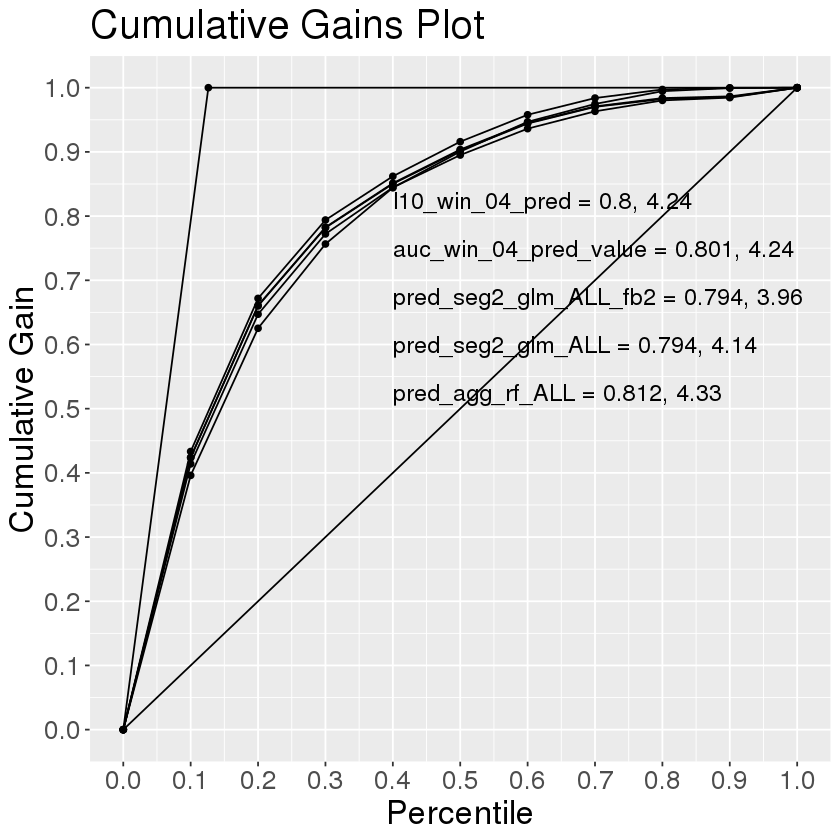

In [75]:
plot_multigains(            lift_df_list=lift_list,
                             auc_list = auc_list,
                             prop_positive = 0.1262565) 

# Compare Metrics

In [97]:
l10_df <- lapply(lift_list, function(x) x[x$P=='0.1','lift'])
l10_df
(l10_df$l10_win_04_pred-l10_df$pred_seg2_glm_ALL_fb2)/l10_df$pred_seg2_glm_ALL_fb2
(l10_df$auc_win_04_pred-l10_df$pred_seg2_glm_ALL_fb2)/l10_df$pred_seg2_glm_ALL_fb2

$l10_win_04_pred
[1] 4.237004

$auc_win_04_pred_value
[1] 4.2394

$pred_seg2_glm_ALL_fb2
[1] 3.960712

$pred_seg2_glm_ALL
[1] 4.139583

$pred_agg_rf_ALL
[1] 4.332828

[1] 0.06975806

[1] 0.0703629

In [102]:
data.frame(auc_list) 

(auc_list$l10_win_04_pred-auc_list$pred_seg2_glm_ALL_fb2)/auc_list$pred_seg2_glm_ALL_fb2
(auc_list$auc_win_04_pred-auc_list$pred_seg2_glm_ALL_fb2)/auc_list$pred_seg2_glm_ALL_fb2

l10_win_04_pred,auc_win_04_pred_value,pred_seg2_glm_ALL_fb2,pred_seg2_glm_ALL,pred_agg_rf_ALL
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.8000359,0.8008584,0.7938074,0.7937036,0.8115667


[1] 0.007846412

[1] 0.00888254

In [103]:
head(expiry_df_test_preds_assign)

,tld_registrar_index,reseller,reseller_country,domain_id,renewal_type,renewed_count,expiry_date,creation_date,status,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,⋯,pred_seg2_glm_ALL,pred_seg2_rf_ALL,reseller_geo,pred_agg_glm_ALL_fb,pred_agg_rf_ALL_fb,pred_agg_glm_fb,pred_agg_rf_fb,pred_seg_glm_ALL_fb,pred_seg_rf_ALL_fb,pred_seg2_glm_ALL_fb,pred_seg2_rf_ALL_fb,reg_arpt_org,reg_arpt_slab,pred_seg2_rf_ALL_fb2,pred_seg2_glm_ALL_fb2,pred_seg_rf_ALL_fb2,pred_seg_glm_ALL_fb2,pred_agg_rf_fb2,pred_agg_glm_fb2,pred_agg_rf_ALL_fb2,pred_agg_glm_ALL_fb2,l10_win_04_pred_model,auc_win_04_pred_model,l10_win_04_pred_value,auc_win_04_pred_value
,<fct>,<fct>,<fct>,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<int>,⋯,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>
1,fun1api,1API,Germany,77112544,FirstTime,1,2019-09-21,2018-09-21,Active,alparty.fun,1API,NA,1,3,3,0,233136706,auto-renewal,unrealized,Not Renewd,2019-09-21,15,3.58,alparty,1,⋯,0.4780584,0.6233142,EU,NA,NA,NA,NA,NA,NA,NA,NA,3,"(1,3]",0.211,0.211,0.211,0.211,0.211,0.211,0.211,0.211,l10_seg2_glm,auc_seg2_glm,0.4780584,0.4780584
2,fun1api,1API,Germany,118771316,FirstTime,1,2020-08-20,2019-08-20,Active,echt-geil.fun,1API,NA,1,5,5,0,329057769,renewal,NA,Renewed,2020-07-13,15,2.00,echt-geil,1,⋯,NA,0.4911790,EU,NA,NA,NA,NA,NA,NA,NA,NA,5,"(3,5]",0.350,0.350,0.350,0.350,0.350,0.350,0.350,0.350,l10_seg2_glm,auc_seg2_glm,NA,NA
3,fun1api,1API,Germany,101717674,FirstTime,1,2020-04-24,2019-04-24,Active,gotsome.fun,1API,NA,1,5,5,0,310645094,auto-renewal,unrealized,Not Renewd,2020-04-24,15,6.09,gotsome,1,⋯,0.6194136,0.6294112,EU,NA,NA,NA,NA,NA,NA,NA,NA,5,"(3,5]",0.350,0.350,0.350,0.350,0.350,0.350,0.350,0.350,l10_seg2_glm,auc_seg2_glm,0.6194136,0.6194136
4,fun1api,1API,Germany,89153032,FirstTime,1,2019-12-29,2018-12-29,Active,noor.fun,1API,NA,1,3,3,0,263535836,renewal,NA,Renewed,2019-12-08,15,5.77,noor,1,⋯,0.4426250,0.3342575,EU,NA,NA,NA,NA,NA,NA,NA,NA,3,"(1,3]",0.211,0.211,0.211,0.211,0.211,0.211,0.211,0.211,l10_seg2_glm,auc_seg2_glm,0.4426250,0.4426250
5,fun1api,1API,Germany,118627451,FirstTime,1,2020-08-19,2019-08-19,Active,laurendoesstuff.fun,1API,NA,1,5,5,0,338522944,auto-renewal,unrealized,Not Renewd,2020-08-19,15,4.83,laurendoesstuff,1,⋯,0.7268515,0.6059519,EU,NA,NA,NA,NA,NA,NA,NA,NA,5,"(3,5]",0.350,0.350,0.350,0.350,0.350,0.350,0.350,0.350,l10_seg2_glm,auc_seg2_glm,0.7268515,0.7268515
6,fun1api,1API,Germany,93057463,FirstTime,1,2020-02-07,2019-02-07,Active,bottegaveneta.fun,1API,NA,1,5,5,0,289674366,auto-renewal,realized,Renewed,2020-02-07,15,5.21,bottegaveneta,1,⋯,0.7021113,0.6055075,EU,NA,NA,NA,NA,NA,NA,NA,NA,5,"(3,5]",0.350,0.350,0.350,0.350,0.350,0.350,0.350,0.350,l10_seg2_glm,auc_seg2_glm,0.7021113,0.7021113


In [105]:
# agg_rf vs. seg2_glm Sensitivity & Specificity at cutoff of .5 and =proppos

compare_function <- function(preds_df){
    compare_df = as.data.frame(list(
        'agg_rf_0.089'=confusionMatrix(as.factor(ifelse(preds_df$pred_agg_rf_ALL > 0.08937016, "Renewed", "Not Renewd")), 
                preds_df$renewal_status, positive="Renewed")$byClass,
        'seg2_glm_fb_0.089'=confusionMatrix(as.factor(ifelse(preds_df$pred_seg2_glm_ALL_fb2 > 0.08937016, "Renewed", "Not Renewd")), 
                preds_df$renewal_status, positive="Renewed")$byClass,
        'l10_win_04_0.089'=confusionMatrix(as.factor(ifelse(preds_df$l10_win_04_pred_value > 0.08937016, "Renewed", "Not Renewd")), 
                preds_df$renewal_status, positive="Renewed")$byClass,
        'auc_win_04_0.089'=confusionMatrix(as.factor(ifelse(preds_df$auc_win_04_pred_value > 0.08937016, "Renewed", "Not Renewd")), 
                preds_df$renewal_status, positive="Renewed")$byClass,
        'agg_rf_0.500'=confusionMatrix(as.factor(ifelse(preds_df$pred_agg_rf_ALL > 0.5, "Renewed", "Not Renewd")), 
                preds_df$renewal_status, positive="Renewed")$byClass,
        'seg2_glm_fb_0.500'=confusionMatrix(as.factor(ifelse(preds_df$pred_seg2_glm_ALL_fb2 > 0.5, "Renewed", "Not Renewd")), 
                preds_df$renewal_status, positive="Renewed")$byClass,
        'l10_win_04_0.500'=confusionMatrix(as.factor(ifelse(preds_df$l10_win_04_pred_value > 0.5, "Renewed", "Not Renewd")), 
                preds_df$renewal_status, positive="Renewed")$byClass,
        'auc_win_04_0.500'=confusionMatrix(as.factor(ifelse(preds_df$auc_win_04_pred_value > 0.5, "Renewed", "Not Renewd")), 
                preds_df$renewal_status, positive="Renewed")$byClass))
    return(compare_df)
}

# confres_list <- lapply(preds_prio_list,compare_function)
compare_function(expiry_df_test_preds_assign)

,agg_rf_0.089,seg2_glm_fb_0.089,l10_win_04_0.089,auc_win_04_0.089,agg_rf_0.500,seg2_glm_fb_0.500,l10_win_04_0.500,auc_win_04_0.500
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Sensitivity,0.8354228,0.8099497,0.8292447,0.8311007,0.30032740,0.21448535,0.29414138,0.28994513
Specificity,0.7122796,0.7106180,0.7148401,0.7138091,0.97377227,0.97804163,0.97316960,0.97356348
Pos Pred Value,0.2955618,0.2879734,0.2945172,0.2942319,0.62330129,0.58531270,0.61147458,0.61157447
Neg Pred Value,0.9676909,0.9627922,0.9668448,0.9671475,0.90593969,0.89601260,0.90569374,0.90522098
Precision,0.2955618,0.2879734,0.2945172,0.2942319,0.62330129,0.58531270,0.61147458,0.61157447
Recall,0.8354228,0.8099497,0.8292447,0.8311007,0.30032740,0.21448535,0.29414138,0.28994513
F1,0.4366444,0.4248822,0.4346594,0.4346028,0.40534569,0.31393174,0.39721027,0.39338698
Prevalence,0.1262565,0.1262565,0.1255369,0.1255369,0.12625647,0.12625647,0.12553692,0.12553692
Detection Rate,0.1054775,0.1022614,0.1041008,0.1043338,0.03791828,0.02708016,0.03692560,0.03639882


In [109]:
x = compare_function(expiry_df_test_preds_assign)

cat("True Positive Improvement via L10 assignment  @ 0.089 cutoff")
(x['Sensitivity','l10_win_04_0.089']-
                                  x['Sensitivity','seg2_glm_fb_0.089'])/x['Sensitivity','seg2_glm_fb_0.089']

cat("\n\nTrue Positive Improvement via L10 assignment  @ 0.500 cutoff")
(x['Sensitivity','l10_win_04_0.500']-
                                  x['Sensitivity','seg2_glm_fb_0.500'])/x['Sensitivity','seg2_glm_fb_0.089']
       
cat("\n\nTrue Positive Improvement via AUC assignment  @ 0.089 cutoff")
(x['Sensitivity','auc_win_04_0.089']-
                                  x['Sensitivity','seg2_glm_fb_0.089'])/x['Sensitivity','seg2_glm_fb_0.089']

cat("\n\nTrue Positive Improvement via AUC assignment  @ 0.500 cutoff")
(x['Sensitivity','auc_win_04_0.500']-
                                  x['Sensitivity','seg2_glm_fb_0.500'])/x['Sensitivity','seg2_glm_fb_0.089']
  

True Positive Improvement via L10 assignment  @ 0.089 cutoff

[1] 0.02382244



True Positive Improvement via L10 assignment  @ 0.500 cutoff

[1] 0.09834689



True Positive Improvement via AUC assignment  @ 0.089 cutoff

[1] 0.02611399



True Positive Improvement via AUC assignment  @ 0.500 cutoff

[1] 0.09316601

# Examining how variables of high importance differ between classes in training & test data

In [84]:
var_imp <- as.data.frame(list(imp_l10=importance(model_l10), 
                              imp_auc=importance(model_auc)))  %>% arrange(desc(imp_l10))
# var_imp$var <- row.names(var_imp)
# row.names(var_imp) <- NULL
# var_imp <- var_imp %>% arrange(desc(imp))
head(var_imp,10)

,imp_l10,imp_auc
,<dbl>,<dbl>
n,31.75366,30.72497
gibbs_rng,23.26031,19.52434
sldlen_kurt,22.90408,24.48538
daydom_rng,21.44615,21.87291
daydom_max,16.89406,16.63842
gibbs_max,15.29106,10.51729
ren_prp,13.16063,20.22859
daydom_kurt,12.83814,26.50903
gibbs_kurt,12.79085,18.07617


In [86]:
train %>% 
  group_by(auc_win_04) %>%
  summarize(mean_n = mean(n), 
           mean_gibbs_rng = mean(gibbs_rng),
           mean_sldlen_kurt = mean(sldlen_kurt),
           mean_daydom_rng = mean(daydom_rng),
           mean_daydom_max = mean(daydom_max),
           mean_gibbs_max = mean(gibbs_max),
           mean_ren_prp = mean(ren_prp),
           mean_daydom_kurt = mean(daydom_kurt),
           mean_gibbs_kurt = mean(gibbs_kurt),
           mean_daydom_mean = mean(daydom_mean)
           ) %>% t()

`summarise()` ungrouping output (override with `.groups` argument)



auc_win_04,auc_agg_rf_ALL,auc_seg2_glm,auc_seg2_glm_fb
mean_n,1471.4252,105.9897,29.9680
mean_gibbs_rng,42.81494,15.44507,21.77784
mean_sldlen_kurt,2.6127300,-0.6754634,0.1395763
mean_daydom_rng,521.97047,46.65201,8.63200
mean_daydom_max,524.00197,48.10608,9.64000
mean_gibbs_max,43.39378,17.80871,22.93048
mean_ren_prp,0.2806437,0.3946055,0.3890438
mean_daydom_kurt,2.0975765,-0.5600047,0.2552572
mean_gibbs_kurt,56.352897,11.363191,2.979369
mean_daydom_mean,190.287148,20.999453,3.707608


In [87]:
train %>% 
  group_by(l10_win_04) %>%
  summarize(mean_n = mean(n), 
           mean_gibbs_rng = mean(gibbs_rng),
           mean_sldlen_kurt = mean(sldlen_kurt),
           mean_daydom_rng = mean(daydom_rng),
           mean_daydom_max = mean(daydom_max),
           mean_gibbs_max = mean(gibbs_max),
           mean_ren_prp = mean(ren_prp),
           mean_daydom_kurt = mean(daydom_kurt),
           mean_gibbs_kurt = mean(gibbs_kurt),
           mean_daydom_mean = mean(daydom_mean)
           ) %>% t()

`summarise()` ungrouping output (override with `.groups` argument)



l10_win_04,l10_agg_rf_ALL,l10_seg2_glm,l10_seg2_glm_fb
mean_n,1862.91969,116.91719,38.39394
mean_gibbs_rng,49.32479,16.72014,21.52848
mean_sldlen_kurt,3.5601528,-0.6287673,0.7303890
mean_daydom_rng,655.96632,50.82285,9.30303
mean_daydom_max,658.21503,52.23585,10.30303
mean_gibbs_max,49.79671,18.84135,22.42879
mean_ren_prp,0.2574651,0.3905533,0.3675474
mean_daydom_kurt,2.3917029,-0.2916554,0.2974898
mean_gibbs_kurt,70.82100,10.62390,4.71722
mean_daydom_mean,241.889724,20.670345,4.135719
